# Introduction

# set up, settings and import

In [1]:
!ls

sample_data


In [2]:
!pip install torch torchvision line_profiler pillow # you made need to restart runtime : "Runtime > restart runtime"

    100% |████████████████████████████████| 519.5MB 33kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59cce000 @  0x7f9b13eff2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 22.1MB/s 
    100% |████████████████████████████████| 92kB 27.6MB/s 
  Running setup.py bdist_wheel for line-profiler ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/05/7d/9b/aafbe8d78dc2b2c644d2efd2f060ab3258143860142575193a
Successfully built line-profiler
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.


In [3]:
!git clone https://github.com/brendenlake/omniglot.git

Cloning into 'omniglot'...
remote: Enumerating objects: 67, done.
remote: Total 67 (delta 0), reused 0 (delta 0), pack-reused 67
Unpacking objects: 100% (67/67), done.


In [0]:
!mkdir data

In [0]:
!unzip -qq omniglot/python/images_evaluation.zip -d .

In [0]:
!unzip -qq omniglot/python/images_background.zip -d .

In [0]:
!mv images_background/* data

In [0]:
!mv images_evaluation/* data

In [9]:
# load saved models
!git clone https://github.com/bmetge/omniglot_20ways_1shot

Cloning into 'omniglot_20ways_1shot'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [0]:
root = "./data/"
background_path = "./omniglot/python/images_background.zip"
evaluation_path = "./omniglot/python/images_evaluation.zip"

learning_rate=0.001
lr_scheduler_step=20  ##
lr_scheduler_gamma=0.5  ##

#nepochs = 1500
print_freq=1

device= "cuda:0" # put cpu here if you want to use your cpu instead
##device= "cpu"    #### TMP
LOAD_MODEL = True

In [95]:
import torch
import torch.nn as nn
import torchvision
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from os.path import join as pj
import os
import zipfile
from tqdm import tqdm
import numpy as np
from itertools import chain
from sklearn.manifold import TSNE
from google.colab import files
from line_profiler import LineProfiler



%matplotlib inline
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [0]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    try:
        if os.path.exists(filename):
            with open(filename, 'rb') as input:
                return pickle.load(input)
        else:
            return None
    except Exception as e:
        print("Error while loading object :" + str(e))
        return None
        

# How I speeded up the loss calculation fonction

In [0]:
# original
def euclidean_dist(x, y):
    '''
        Compute euclidean distance between two tensors
    '''
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d) ## on copie m fois x
    y = y.unsqueeze(0).expand(n, m, d) ## on copie n fois y
    return torch.pow(x - y, 2).sum(2)  ## 

# boosted with broadcasting
def ec(x,y):
    xy = x.mm(y.t())  ## mm : matrix multiplication / .t() : transpose
    xnorm = (x*x).sum(1).unsqueeze(1)  ## 
    ynorm = (y*y).sum(1).unsqueeze(0)
    return (xnorm + ynorm - 2*xy)

In [0]:
x = torch.from_numpy(np.random.rand(10000,1))
y = torch.from_numpy(np.random.rand(10000,1))

In [98]:
lp = LineProfiler()
lp_wrapper = lp(euclidean_dist)
lp_wrapper(x,y)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 3.36725 s
File: <ipython-input-96-42d81e92a9c2>
Function: euclidean_dist at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def euclidean_dist(x, y):
     2                                               '''
     3                                                   Compute euclidean distance between two tensors
     4                                               '''
     5         1         17.0     17.0      0.0      n = x.size(0)
     6         1          3.0      3.0      0.0      m = y.size(0)
     7         1          0.0      0.0      0.0      d = x.size(1)
     8         1        483.0    483.0      0.0      x = x.unsqueeze(1).expand(n, m, d) ## on copie m fois x
     9         1         49.0     49.0      0.0      y = y.unsqueeze(0).expand(n, m, d) ## on copie n fois y
    10         1    3366695.0 3366695.0    100.0      return torch.pow(x - y, 2).sum(2)  ## 



In [99]:
lp = LineProfiler()
lp_wrapper = lp(ec)
lp_wrapper(x,y)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 1.90913 s
File: <ipython-input-96-42d81e92a9c2>
Function: ec at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def ec(x,y):
    14         1     306374.0 306374.0     16.0      xy = x.mm(y.t())  ## mm : matrix multiplication / .t() : transpose
    15         1        490.0    490.0      0.0      xnorm = (x*x).sum(1).unsqueeze(1)  ## 
    16         1        357.0    357.0      0.0      ynorm = (y*y).sum(1).unsqueeze(0)
    17         1    1601905.0 1601905.0     83.9      return (xnorm + ynorm - 2*xy)



# Model Definition

In [0]:
def conv_block_shallow(in_channels, out_channels):
    '''
    returns a block conv-bn-relu-pool
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

def conv_block_deep(in_channels, out_channels):
    '''
    returns a block conv-bn-relu-pool
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        
        nn.MaxPool2d(2)
    )

class ProtoNet(nn.Module):
    '''
    Model as described in the reference paper,
    source: https://github.com/jakesnell/prototypical-networks/blob/f0c48808e496989d01db59f86d4449d7aee9ab0c/protonets/models/few_shot.py#L62-L84
    '''
    def __init__(self, x_dim=1, hid_dim=64, z_dim=64, conv_block=conv_block_deep):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim,   hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)
    
# utils 
def get_model(model_path, conv_block=conv_block_deep):
    if os.path.exists(model_path):
        try:
            model = ProtoNet(conv_block=conv_block).to(device)
            model.load_state_dict(torch.load(model_path))#, map_location={'cuda:0': 'cpu'}))   #### TMP check if this works with GPU !!!!!!
            return model
        except Exception as e:
            print("Error while loading model :" + str(e))
            return None
    else:
        return None


In [0]:
def train_split():
    with zipfile.ZipFile(background_path) as f:
        x = set(map(lambda x:x.filename.split("/")[1], f.filelist))
        return list(filter(lambda x:len(x)>0, x))

def test_split():
    with zipfile.ZipFile(evaluation_path) as f:
        x = set(map(lambda x:x.filename.split("/")[1], f.filelist))
        return list(filter(lambda x:len(x)>0, x))

# used : from training time augmentation
#def load_data(classes):
#    x, y, cur = [],[],0
#    for cl in tqdm(classes):
#        for ch in os.listdir(pj(root, cl)):
#            base = pj(root, cl, ch)
#            for im in filter(lambda x:x.endswith(".png"), os.listdir(base)):
#                im = Image.open(pj(base, im)).resize((28,28))
#                x.append(im)
#                y.append(cur)
#            cur+=1
#    y = torch.LongTensor(y).to(device)
#    return x,y


#######################
# test time augmentation
def load_data(classes):
    """
        Load the file data in memory 
        (without any operation on it)
    """
    x, y, cur = [],[],0
    for cl in tqdm(classes):
        for ch in os.listdir(pj(root, cl)):
            base = pj(root, cl, ch)
            for im in filter(lambda x:x.endswith(".png"), os.listdir(base)):
                im = read_image(pj(base, im))
                x.append(im)
                y.append(cur)
            cur+=1
    y = torch.LongTensor(y).to(device)
    return x,y

def read_image(fp, size=(28,28)):
    im = Image.open(fp)
    im = im.convert("L")
    im = ImageOps.invert(im)
    return im.resize(size)
    return im#.resize(size)




# used : from training time augmentation
#def transform_dataset(x, aff=lambda x:x):
#    x = [torch.from_numpy(1-np.array(aff(im)).astype("uint8")).unsqueeze(0) for im in x]
#    return torch.cat(x).float().to(device)
#######################
# test time augmentation
def transform_dataset(images, aff=lambda x:x):
    x = [transform_image(im, aff) for im in images]
    return torch.cat(x).float().to(device)

def transform_image(im, aff):
    im = aff(im)
    im = im.resize((28,28))
    im = np.array(im)
    im = torch.from_numpy(im)
    return im.unsqueeze(0)


def get_batch_ids(n_class, n_way, k_shot, n_samp=20):
    cid  = np.random.choice(n_class, n_way, replace=False).repeat(k_shot) 
    offs = np.concatenate([np.random.choice(n_samp, k_shot, replace=False) for i in range(n_way)])
    return cid*n_samp + offs

def sample_set_ids(ids):
    return ids[::2], ids[1::2]
    
def index_bid(x, support, query):
    return x[support], x[query]

def sample_batch(x, n_class, n_way, k_shot, n_samp=20):
    bid = get_batch_ids(n_class, n_way, k_shot, n_samp)
    support, query = sample_set_ids(bid)
    return index_bid(x, support, query)

class OmniGlotDs():
    def __init__(self, classes, k_shot=5, n_way=60, n_samp=20, n_iter=1000, transform=None):
        self.x,self.y = load_data(classes)
        self.n_class = len(self.y.cpu().unique())
        self.n_iter = n_iter
        self.k_shot = k_shot
        self.n_way  = n_way
        self.n_samp = n_samp
        self.transform = transform if transform else lambda x:x
        self._generate_split()
        
    def _generate_split(self):
        self.X = transform_dataset(self.x, self.transform)
        
    def sample(self):
        return sample_batch(self.X, self.n_class, self.n_way, 
                            self.k_shot*2, self.n_samp)
    
    def __iter__(self):            
        for i in range(self.n_iter):
            yield self.sample()
            
    def __len__(self):
        return self.n_iter

In [0]:
def ec(x,y):
    xy = x.mm(y.t()) 
    xnorm = (x*x).sum(1).unsqueeze(1)
    ynorm = (y*y).sum(1).unsqueeze(0)
    return (xnorm + ynorm - 2*xy) 
 
def lossfunc(proto, query, lbl):
    dists = ec(query, proto)
    loss  = torch.nn.CrossEntropyLoss()(-dists, lbl)
    acc   = (dists.min(1)[1]==lbl).float().mean().item()
    return loss, acc

def test_model(model, ds):
    '''
        Train the model with the prototypical learning algorithm
    '''
    accuracy = []
    model.eval()
    n_way = ds.n_way
    k_shot = ds.k_shot
    lbl = torch.from_numpy(np.arange(n_way).repeat(k_shot)).to(device)
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(ds.n_way, ds.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        _, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
    return accuracy

def get_loss_acc(model, ds):
    '''
        Train the model with the prototypical learning algorithm
    '''
    accuracy = []
    losses = []
    model.eval()
    n_way = ds.n_way
    k_shot = ds.k_shot
    lbl = torch.from_numpy(np.arange(n_way).repeat(k_shot)).to(device)
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(ds.n_way, ds.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        loss, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
        losses.append(loss)
    return losses, accuracy

def train_epoch(model, optim, ds):
    '''
        Train the model with the prototypical learning algorithm
    '''
    model.train()
    ds._generate_split()
    n_way = ds.n_way
    k_shot = ds.k_shot
    lbl = torch.from_numpy(np.arange(n_way).repeat(k_shot)).to(device)
    losses, accuracies = [],[]
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        
        proto = out[:n_way*k_shot]
        proto = proto.view(ds.n_way, ds.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        loss, acc = lossfunc(proto, query, lbl)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        accuracies.append(acc)
    return losses, accuracies

def train_model(model, optim, ds_train, ds_test, lr_scheduler, nepochs=10, print_freq=2):
    '''
        Train the model with the prototypical learning algorithm
    '''
    losses, tr_acc, te_acc = [],[],[]
    for epoch in range(nepochs):
        loss, acc = train_epoch(model, optim, ds_train)
        losses.append(loss)
        tr_acc.append(acc)
        print('Training Avg Loss: {}, Avg Acc: {}'.format(np.mean(loss), np.mean(acc)))
        if epoch % print_freq==0:
            acc = test_model(model, ds_test)
            te_acc.append(acc)
            print('Test Accuracy: {}'.format(np.mean(acc)))
        lr_scheduler.step()
    return losses, tr_acc, te_acc

In [0]:
test_class = test_split()
train_class = train_split()
nepochs = 50
nepochs = 2
print_freq=1
device="cuda:0"
##device="cpu"    ### TMP

# effect of data augmentation visualisation

In [0]:
test_class = test_split()

In [0]:
ds_test = OmniGlotDs(test_class, k_shot=1, n_iter=1000)

100%|██████████| 20/20 [00:03<00:00,  4.34it/s]


In [0]:
Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1), resample=Image.BILINEAR)

In [0]:
a = ds_test.x[0]

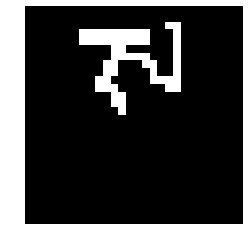

In [0]:
#plt.style.use("dark_background")
plt.axis('off')

plt.imshow(np.array(a), cmap="gray")

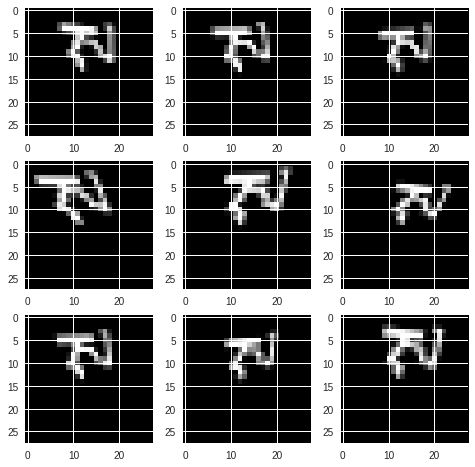

In [0]:
#plt.axis('off')

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = Aff(a)
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.array(img), cmap='gray')
plt.show()

# Model validation

In [158]:
#### ATTENTION -> no LOAD_MODEL here because we below plots the train acc and test acc evolution with epochs


no_augmentation  = lambda x:x
no_augmentation.__name__ = "no_augmentation"
yes_augmentation = Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1))
yes_augmentation.__name__ = "yes_augmentation"

results = {}
models = {}

n_iter = 1000
nepochs = 50
print_freq = 1

for Aff in [no_augmentation, yes_augmentation]:

        for conv_block in [conv_block_shallow, conv_block_deep]:
            key_path = Aff.__name__ + "_" + conv_block.__name__ + "_" + str(nepochs) + "_epochs"
            print("STATUS :   " + key_path)
            model_path_validation = "./omniglot_20ways_1shot/saved_models/model_validation_" + key_path
            result_pickle_name = "./omniglot_20ways_1shot/saved_results/result_validation_" + key_path + ".pkl"
            #if LOAD_MODEL:
            model_nways = get_model(model_path_validation,conv_block=conv_block)
            if model_nways:
                print('MODEL UPLOADED')
                models[(key_path)] = model_nways
                #losses, tr_acc = None, None # no relevant here #get_loss_acc(model_nways, ds_train)
                #tr_acc = test_model(model_nways, ds_train)
                result = load_object(result_pickle_name)
                if result:
                    print('Results successfully retrived')
                    results[(key_path)] = result
                else:
                    print("Enable to load results !!!")
            else:
                print('MODEL NOT FOUND , creating one...')
                ds_train = OmniGlotDs(train_class, transform=Aff, k_shot=1, n_iter=n_iter)
                ds_test  = OmniGlotDs(test_class, k_shot=1, n_way=20, n_iter=n_iter)
                model = ProtoNet(conv_block=conv_block).to(device)
                optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                               gamma=lr_scheduler_gamma,
                                                               step_size=lr_scheduler_step)
                # Augmentation
                losses, tr_acc, te_acc = train_model(model, optim, ds_train, ds_test, lr_scheduler, nepochs=nepochs, print_freq=print_freq)
                results[(key_path)] = losses, tr_acc, te_acc
                models[(key_path)] = model
                # saving the model
                try:
                    print("Saving the model " + Aff.__name__ + conv_block.__name__)
                    torch.save(model.state_dict(), model_path_validation)
                    files.download(model_path_validation)
                except Exception as e:
                    print("Exception while saving model :" + str(e))
                # saving the result
                try:
                    print("Saving the results " + Aff.__name__ + conv_block.__name__)
                    save_object(filename=result_pickle_name,obj=results[(key_path)])
                    files.download(result_pickle_name)
                except Exception as e:
                    print("Exception while saving results :" + str(e))




 16%|█▌        | 156/1000 [00:00<00:04, 170.12it/s]

 17%|█▋        | 174/1000 [00:01<00:04, 172.84it/s]

 19%|█▉        | 192/1000 [00:01<00:04, 173.83it/s]

 21%|██        | 210/1000 [00:01<00:04, 172.27it/s]

 23%|██▎       | 227/1000 [00:01<00:04, 169.23it/s]

 24%|██▍       | 245/1000 [00:01<00:04, 171.79it/s]

 26%|██▋       | 263/1000 [00:01<00:04, 172.46it/s]

 28%|██▊       | 281/1000 [00:01<00:04, 171.89it/s]

 30%|██▉       | 299/1000 [00:01<00:04, 169.90it/s]

 32%|███▏      | 316/1000 [00:01<00:04, 169.08it/s]

 33%|███▎      | 334/1000 [00:01<00:03, 169.51it/s]

 35%|███▌      | 351/1000 [00:02<00:03, 169.59it/s]

 37%|███▋      | 369/1000 [00:02<00:03, 170.11it/s]

 39%|███▊      | 387/1000 [00:02<00:03, 169.95it/s]

 40%|████      | 404/1000 [00:02<00:03, 164.17it/s]

 42%|████▏     | 421/1000 [00:02<00:03, 165.00it/s]

 44%|████▍     | 438/1000 [00:02<00:03, 166.32it/s]

 46%|████▌     | 455/1000 [00:02<00:03, 164.41it/s]

 47%|████▋     | 472/1000 [00:02<00:03, 165.

Test Accuracy: 0.9241000096797943




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<00:27, 36.68it/s]

  1%|          | 8/1000 [00:00<00:27, 35.75it/s]

  1%|          | 12/1000 [00:00<00:28, 35.25it/s]

  2%|▏         | 16/1000 [00:00<00:27, 35.55it/s]

  2%|▏         | 20/1000 [00:00<00:26, 36.61it/s]

  2%|▏         | 24/1000 [00:00<00:26, 37.53it/s]

  3%|▎         | 28/1000 [00:00<00:25, 38.20it/s]

  3%|▎         | 33/1000 [00:00<00:24, 39.32it/s]

  4%|▍         | 38/1000 [00:00<00:23, 40.16it/s]

  4%|▍         | 43/1000 [00:01<00:23, 40.70it/s]

  5%|▍         | 48/1000 [00:01<00:23, 41.26it/s]

  5%|▌         | 53/1000 [00:01<00:22, 41.22it/s]

  6%|▌         | 58/1000 [00:01<00:22, 41.51it/s]

  6%|▋         | 63/1000 [00:01<00:22, 41.92it/s]

  7%|▋         | 68/1000 [00:01<00:22, 42.29it/s]

  7%|▋         | 73/1000 [00:01<00:21, 42.66it/s]

  8%|▊         | 78/1000 [00:01<00:21, 43.41it/s]

  8%|▊         | 83/1000 [00:02<00:20, 43.70it/s]

  9%|▉         | 88/1000 [00:02<00:20, 4

Training Avg Loss: 0.3208355257511139, Avg Acc: 0.890650044977665




  4%|▎         | 35/1000 [00:00<00:05, 172.49it/s]

  5%|▌         | 53/1000 [00:00<00:05, 173.33it/s]

  7%|▋         | 71/1000 [00:00<00:05, 174.12it/s]

  9%|▉         | 89/1000 [00:00<00:05, 174.16it/s]

 11%|█         | 107/1000 [00:00<00:05, 174.22it/s]

 12%|█▎        | 125/1000 [00:00<00:05, 174.03it/s]

 14%|█▍        | 142/1000 [00:00<00:04, 172.74it/s]

 16%|█▌        | 159/1000 [00:00<00:05, 166.00it/s]

 18%|█▊        | 176/1000 [00:01<00:04, 167.15it/s]

 19%|█▉        | 193/1000 [00:01<00:04, 167.57it/s]

 21%|██        | 211/1000 [00:01<00:04, 170.49it/s]

 23%|██▎       | 229/1000 [00:01<00:04, 171.87it/s]

 25%|██▍       | 247/1000 [00:01<00:04, 171.44it/s]

 26%|██▋       | 265/1000 [00:01<00:04, 172.51it/s]

 28%|██▊       | 283/1000 [00:01<00:04, 173.27it/s]

 30%|███       | 301/1000 [00:01<00:04, 171.92it/s]

 32%|███▏      | 319/1000 [00:01<00:03, 172.41it/s]

 34%|███▎      | 337/1000 [00:01<00:03, 167.21it/s]

 36%|███▌      | 355/1000 [00:02<00:03, 169.35it

Test Accuracy: 0.9246000092029572




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:20, 47.47it/s]

  1%|          | 10/1000 [00:00<00:21, 46.24it/s]

  2%|▏         | 15/1000 [00:00<00:21, 45.57it/s]

  2%|▏         | 20/1000 [00:00<00:21, 45.07it/s]

  2%|▎         | 25/1000 [00:00<00:21, 44.41it/s]

  3%|▎         | 30/1000 [00:00<00:22, 43.98it/s]

  4%|▎         | 35/1000 [00:00<00:21, 44.01it/s]

  4%|▍         | 40/1000 [00:00<00:21, 43.84it/s]

  4%|▍         | 45/1000 [00:01<00:22, 43.24it/s]

  5%|▌         | 50/1000 [00:01<00:21, 43.19it/s]

  6%|▌         | 55/1000 [00:01<00:21, 43.76it/s]

  6%|▌         | 60/1000 [00:01<00:21, 43.74it/s]

  6%|▋         | 65/1000 [00:01<00:21, 43.88it/s]

  7%|▋         | 70/1000 [00:01<00:21, 43.66it/s]

  8%|▊         | 75/1000 [00:01<00:21, 43.63it/s]

  8%|▊         | 80/1000 [00:01<00:21, 43.52it/s]

  8%|▊         | 85/1000 [00:01<00:21, 43.06it/s]

  9%|▉         | 90/1000 [00:02<00:21, 42.85it/s]

 10%|▉         | 95/1000 [00:02<00:21, 

Training Avg Loss: 0.3262716071307659, Avg Acc: 0.8893667101264




  4%|▎         | 35/1000 [00:00<00:05, 168.58it/s]

  5%|▌         | 53/1000 [00:00<00:05, 169.08it/s]

  7%|▋         | 70/1000 [00:00<00:05, 169.21it/s]

  9%|▉         | 88/1000 [00:00<00:05, 170.20it/s]

 11%|█         | 106/1000 [00:00<00:05, 171.08it/s]

 12%|█▏        | 122/1000 [00:00<00:05, 164.07it/s]

 14%|█▍        | 139/1000 [00:00<00:05, 165.47it/s]

 16%|█▌        | 156/1000 [00:00<00:05, 165.99it/s]

 17%|█▋        | 174/1000 [00:01<00:04, 168.98it/s]

 19%|█▉        | 191/1000 [00:01<00:04, 167.54it/s]

 21%|██        | 209/1000 [00:01<00:04, 168.86it/s]

 23%|██▎       | 226/1000 [00:01<00:04, 169.06it/s]

 24%|██▍       | 244/1000 [00:01<00:04, 170.00it/s]

 26%|██▌       | 261/1000 [00:01<00:04, 169.28it/s]

 28%|██▊       | 279/1000 [00:01<00:04, 169.82it/s]

 30%|██▉       | 296/1000 [00:01<00:04, 162.56it/s]

 31%|███▏      | 314/1000 [00:01<00:04, 165.18it/s]

 33%|███▎      | 332/1000 [00:01<00:03, 167.74it/s]

 35%|███▌      | 350/1000 [00:02<00:03, 169.61it

Test Accuracy: 0.9192000100016594




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<00:27, 35.64it/s]

  1%|          | 8/1000 [00:00<00:28, 35.31it/s]

  1%|          | 12/1000 [00:00<00:27, 35.56it/s]

  2%|▏         | 16/1000 [00:00<00:27, 36.40it/s]

  2%|▏         | 20/1000 [00:00<00:26, 37.23it/s]

  2%|▎         | 25/1000 [00:00<00:25, 38.18it/s]

  3%|▎         | 29/1000 [00:00<00:25, 38.62it/s]

  3%|▎         | 34/1000 [00:00<00:24, 40.02it/s]

  4%|▍         | 39/1000 [00:00<00:23, 41.36it/s]

  4%|▍         | 44/1000 [00:01<00:22, 41.94it/s]

  5%|▍         | 49/1000 [00:01<00:22, 42.58it/s]

  5%|▌         | 54/1000 [00:01<00:21, 43.35it/s]

  6%|▌         | 59/1000 [00:01<00:21, 43.79it/s]

  6%|▋         | 64/1000 [00:01<00:21, 43.80it/s]

  7%|▋         | 69/1000 [00:01<00:21, 43.46it/s]

  7%|▋         | 74/1000 [00:01<00:21, 43.23it/s]

  8%|▊         | 79/1000 [00:01<00:21, 43.37it/s]

  8%|▊         | 84/1000 [00:02<00:21, 43.48it/s]

  9%|▉         | 89/1000 [00:02<00:20, 4

Training Avg Loss: 0.322681897521019, Avg Acc: 0.890166709780693




  4%|▍         | 38/1000 [00:00<00:05, 184.40it/s]

  6%|▌         | 56/1000 [00:00<00:05, 182.26it/s]

  7%|▋         | 74/1000 [00:00<00:05, 180.97it/s]

  9%|▉         | 92/1000 [00:00<00:05, 179.88it/s]

 11%|█         | 110/1000 [00:00<00:04, 178.15it/s]

 13%|█▎        | 128/1000 [00:00<00:04, 178.17it/s]

 14%|█▍        | 145/1000 [00:00<00:04, 172.82it/s]

 16%|█▋        | 163/1000 [00:00<00:04, 173.46it/s]

 18%|█▊        | 181/1000 [00:01<00:04, 174.67it/s]

 20%|█▉        | 199/1000 [00:01<00:04, 175.78it/s]

 22%|██▏       | 217/1000 [00:01<00:04, 175.91it/s]

 24%|██▎       | 235/1000 [00:01<00:04, 173.14it/s]

 25%|██▌       | 253/1000 [00:01<00:04, 172.48it/s]

 27%|██▋       | 271/1000 [00:01<00:04, 173.33it/s]

 29%|██▉       | 289/1000 [00:01<00:04, 175.03it/s]

 31%|███       | 307/1000 [00:01<00:03, 175.36it/s]

 32%|███▎      | 325/1000 [00:01<00:03, 169.90it/s]

 34%|███▍      | 343/1000 [00:01<00:03, 172.11it/s]

 36%|███▌      | 361/1000 [00:02<00:03, 171.60it

Test Accuracy: 0.9220000094771386




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:21, 47.31it/s]

  1%|          | 10/1000 [00:00<00:21, 46.99it/s]

  2%|▏         | 15/1000 [00:00<00:21, 45.57it/s]

  2%|▏         | 20/1000 [00:00<00:21, 45.66it/s]

  2%|▎         | 25/1000 [00:00<00:21, 45.65it/s]

  3%|▎         | 30/1000 [00:00<00:21, 44.89it/s]

  4%|▎         | 35/1000 [00:00<00:21, 45.21it/s]

  4%|▍         | 40/1000 [00:00<00:21, 44.84it/s]

  4%|▍         | 45/1000 [00:01<00:21, 44.45it/s]

  5%|▌         | 50/1000 [00:01<00:21, 44.35it/s]

  6%|▌         | 55/1000 [00:01<00:21, 44.16it/s]

  6%|▌         | 60/1000 [00:01<00:21, 44.62it/s]

  6%|▋         | 65/1000 [00:01<00:20, 44.96it/s]

  7%|▋         | 70/1000 [00:01<00:20, 44.74it/s]

  8%|▊         | 75/1000 [00:01<00:20, 44.75it/s]

  8%|▊         | 80/1000 [00:01<00:20, 44.35it/s]

  8%|▊         | 85/1000 [00:01<00:20, 44.15it/s]

  9%|▉         | 90/1000 [00:02<00:20, 43.92it/s]

 10%|▉         | 95/1000 [00:02<00:20, 

Training Avg Loss: 0.31810474865883587, Avg Acc: 0.8920667106509209




  4%|▎         | 35/1000 [00:00<00:05, 176.09it/s]

  5%|▌         | 52/1000 [00:00<00:05, 171.93it/s]

  7%|▋         | 70/1000 [00:00<00:05, 172.03it/s]

  9%|▉         | 88/1000 [00:00<00:05, 173.50it/s]

 11%|█         | 107/1000 [00:00<00:05, 175.84it/s]

 13%|█▎        | 126/1000 [00:00<00:04, 177.39it/s]

 14%|█▍        | 144/1000 [00:00<00:04, 176.65it/s]

 16%|█▌        | 162/1000 [00:00<00:04, 177.29it/s]

 18%|█▊        | 180/1000 [00:01<00:04, 177.78it/s]

 20%|█▉        | 198/1000 [00:01<00:04, 178.29it/s]

 22%|██▏       | 216/1000 [00:01<00:04, 176.83it/s]

 23%|██▎       | 234/1000 [00:01<00:04, 172.57it/s]

 25%|██▌       | 252/1000 [00:01<00:04, 173.26it/s]

 27%|██▋       | 270/1000 [00:01<00:04, 175.07it/s]

 29%|██▉       | 289/1000 [00:01<00:04, 176.97it/s]

 31%|███       | 307/1000 [00:01<00:03, 176.34it/s]

 32%|███▎      | 325/1000 [00:01<00:03, 176.71it/s]

 34%|███▍      | 343/1000 [00:01<00:03, 175.98it/s]

 36%|███▌      | 361/1000 [00:02<00:03, 176.62it

Test Accuracy: 0.9227500097751618




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<00:27, 35.94it/s]

  1%|          | 8/1000 [00:00<00:27, 36.25it/s]

  1%|          | 12/1000 [00:00<00:27, 36.39it/s]

  2%|▏         | 16/1000 [00:00<00:26, 36.89it/s]

  2%|▏         | 20/1000 [00:00<00:26, 37.19it/s]

  2%|▏         | 24/1000 [00:00<00:25, 37.96it/s]

  3%|▎         | 29/1000 [00:00<00:24, 39.04it/s]

  3%|▎         | 34/1000 [00:00<00:24, 40.23it/s]

  4%|▍         | 39/1000 [00:00<00:23, 41.11it/s]

  4%|▍         | 44/1000 [00:01<00:22, 41.91it/s]

  5%|▍         | 49/1000 [00:01<00:22, 42.35it/s]

  5%|▌         | 54/1000 [00:01<00:21, 43.22it/s]

  6%|▌         | 59/1000 [00:01<00:21, 43.28it/s]

  6%|▋         | 64/1000 [00:01<00:21, 43.77it/s]

  7%|▋         | 69/1000 [00:01<00:21, 44.00it/s]

  7%|▋         | 74/1000 [00:01<00:20, 44.21it/s]

  8%|▊         | 79/1000 [00:01<00:20, 44.36it/s]

  8%|▊         | 84/1000 [00:02<00:20, 44.43it/s]

  9%|▉         | 89/1000 [00:02<00:20, 4

Training Avg Loss: 0.3187048022598028, Avg Acc: 0.8924500439763069




  4%|▎         | 36/1000 [00:00<00:05, 178.41it/s]

  5%|▌         | 54/1000 [00:00<00:05, 178.68it/s]

  7%|▋         | 72/1000 [00:00<00:05, 178.10it/s]

  9%|▉         | 88/1000 [00:00<00:05, 171.50it/s]

 11%|█         | 106/1000 [00:00<00:05, 171.54it/s]

 12%|█▏        | 124/1000 [00:00<00:05, 172.32it/s]

 14%|█▍        | 142/1000 [00:00<00:04, 173.82it/s]

 16%|█▌        | 160/1000 [00:00<00:04, 174.53it/s]

 18%|█▊        | 178/1000 [00:01<00:04, 175.21it/s]

 20%|█▉        | 196/1000 [00:01<00:04, 175.87it/s]

 21%|██▏       | 214/1000 [00:01<00:04, 175.51it/s]

 23%|██▎       | 232/1000 [00:01<00:04, 176.48it/s]

 25%|██▌       | 250/1000 [00:01<00:04, 176.99it/s]

 27%|██▋       | 268/1000 [00:01<00:04, 171.97it/s]

 29%|██▊       | 286/1000 [00:01<00:04, 173.43it/s]

 30%|███       | 304/1000 [00:01<00:03, 174.32it/s]

 32%|███▏      | 323/1000 [00:01<00:03, 176.49it/s]

 34%|███▍      | 341/1000 [00:01<00:03, 175.60it/s]

 36%|███▌      | 359/1000 [00:02<00:03, 176.73it

Test Accuracy: 0.9162500113248825




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:21, 47.38it/s]

  1%|          | 10/1000 [00:00<00:21, 46.80it/s]

  2%|▏         | 15/1000 [00:00<00:21, 45.90it/s]

  2%|▏         | 20/1000 [00:00<00:21, 45.54it/s]

  2%|▎         | 25/1000 [00:00<00:21, 45.42it/s]

  3%|▎         | 30/1000 [00:00<00:21, 44.51it/s]

  4%|▎         | 35/1000 [00:00<00:21, 44.42it/s]

  4%|▍         | 40/1000 [00:00<00:21, 44.66it/s]

  4%|▍         | 45/1000 [00:01<00:21, 44.26it/s]

  5%|▌         | 50/1000 [00:01<00:21, 44.10it/s]

  6%|▌         | 55/1000 [00:01<00:21, 44.09it/s]

  6%|▌         | 60/1000 [00:01<00:21, 44.29it/s]

  6%|▋         | 65/1000 [00:01<00:21, 44.08it/s]

  7%|▋         | 70/1000 [00:01<00:20, 44.30it/s]

  8%|▊         | 75/1000 [00:01<00:20, 44.06it/s]

  8%|▊         | 80/1000 [00:01<00:21, 43.70it/s]

  8%|▊         | 85/1000 [00:01<00:20, 44.18it/s]

  9%|▉         | 90/1000 [00:02<00:20, 44.30it/s]

 10%|▉         | 95/1000 [00:02<00:20, 

Training Avg Loss: 0.3171796620339155, Avg Acc: 0.8939000443220139




  4%|▎         | 36/1000 [00:00<00:05, 176.61it/s]

  5%|▌         | 54/1000 [00:00<00:05, 176.12it/s]

  7%|▋         | 71/1000 [00:00<00:05, 173.72it/s]

  9%|▉         | 89/1000 [00:00<00:05, 174.23it/s]

 11%|█         | 107/1000 [00:00<00:05, 173.24it/s]

 12%|█▏        | 124/1000 [00:00<00:05, 170.01it/s]

 14%|█▍        | 142/1000 [00:00<00:05, 170.78it/s]

 16%|█▌        | 160/1000 [00:00<00:04, 171.21it/s]

 18%|█▊        | 177/1000 [00:01<00:04, 166.30it/s]

 20%|█▉        | 195/1000 [00:01<00:04, 168.21it/s]

 21%|██▏       | 213/1000 [00:01<00:04, 170.29it/s]

 23%|██▎       | 231/1000 [00:01<00:04, 172.31it/s]

 25%|██▍       | 249/1000 [00:01<00:04, 173.09it/s]

 27%|██▋       | 267/1000 [00:01<00:04, 174.79it/s]

 28%|██▊       | 285/1000 [00:01<00:04, 175.52it/s]

 30%|███       | 303/1000 [00:01<00:03, 176.45it/s]

 32%|███▏      | 321/1000 [00:01<00:03, 176.57it/s]

 34%|███▍      | 339/1000 [00:01<00:04, 163.17it/s]

 36%|███▌      | 356/1000 [00:02<00:04, 151.99it

Test Accuracy: 0.9230000094175339




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<00:27, 35.89it/s]

  1%|          | 8/1000 [00:00<00:28, 35.29it/s]

  1%|          | 12/1000 [00:00<00:27, 35.60it/s]

  2%|▏         | 16/1000 [00:00<00:27, 36.20it/s]

  2%|▏         | 21/1000 [00:00<00:26, 37.58it/s]

  3%|▎         | 26/1000 [00:00<00:25, 38.88it/s]

  3%|▎         | 31/1000 [00:00<00:24, 39.97it/s]

  4%|▎         | 35/1000 [00:00<00:24, 39.93it/s]

  4%|▍         | 40/1000 [00:01<00:23, 41.47it/s]

  4%|▍         | 45/1000 [00:01<00:22, 42.08it/s]

  5%|▌         | 50/1000 [00:01<00:22, 42.57it/s]

  6%|▌         | 55/1000 [00:01<00:21, 43.41it/s]

  6%|▌         | 60/1000 [00:01<00:21, 44.34it/s]

  6%|▋         | 65/1000 [00:01<00:20, 44.61it/s]

  7%|▋         | 70/1000 [00:01<00:20, 44.47it/s]

  8%|▊         | 75/1000 [00:01<00:21, 44.03it/s]

  8%|▊         | 80/1000 [00:01<00:20, 44.38it/s]

  8%|▊         | 85/1000 [00:02<00:20, 44.21it/s]

  9%|▉         | 90/1000 [00:02<00:20, 4

Training Avg Loss: 0.3159360906481743, Avg Acc: 0.8921500443220138




  3%|▎         | 33/1000 [00:00<00:06, 158.17it/s]

  5%|▌         | 51/1000 [00:00<00:05, 163.97it/s]

  7%|▋         | 69/1000 [00:00<00:05, 167.53it/s]

  9%|▊         | 87/1000 [00:00<00:05, 169.41it/s]

 10%|█         | 105/1000 [00:00<00:05, 170.74it/s]

 12%|█▏        | 123/1000 [00:00<00:05, 171.38it/s]

 14%|█▍        | 141/1000 [00:00<00:04, 173.40it/s]

 16%|█▌        | 159/1000 [00:00<00:04, 174.66it/s]

 18%|█▊        | 177/1000 [00:01<00:04, 174.13it/s]

 19%|█▉        | 194/1000 [00:01<00:04, 168.32it/s]

 21%|██▏       | 213/1000 [00:01<00:04, 172.02it/s]

 23%|██▎       | 231/1000 [00:01<00:04, 173.22it/s]

 25%|██▍       | 249/1000 [00:01<00:04, 174.62it/s]

 27%|██▋       | 267/1000 [00:01<00:04, 175.84it/s]

 28%|██▊       | 285/1000 [00:01<00:04, 175.52it/s]

 30%|███       | 303/1000 [00:01<00:03, 176.12it/s]

 32%|███▏      | 321/1000 [00:01<00:03, 176.86it/s]

 34%|███▍      | 340/1000 [00:01<00:03, 177.38it/s]

 36%|███▌      | 358/1000 [00:02<00:03, 177.93it

Test Accuracy: 0.9210000092983246




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:20, 48.25it/s]

  1%|          | 10/1000 [00:00<00:21, 46.87it/s]

  2%|▏         | 15/1000 [00:00<00:21, 46.06it/s]

  2%|▏         | 20/1000 [00:00<00:21, 46.09it/s]

  2%|▎         | 25/1000 [00:00<00:21, 45.67it/s]

  3%|▎         | 30/1000 [00:00<00:21, 45.54it/s]

  4%|▎         | 35/1000 [00:00<00:21, 45.28it/s]

  4%|▍         | 40/1000 [00:00<00:21, 45.62it/s]

  4%|▍         | 45/1000 [00:00<00:20, 45.63it/s]

  5%|▌         | 50/1000 [00:01<00:20, 45.95it/s]

  6%|▌         | 55/1000 [00:01<00:20, 46.00it/s]

  6%|▌         | 60/1000 [00:01<00:20, 45.76it/s]

  6%|▋         | 65/1000 [00:01<00:20, 45.21it/s]

  7%|▋         | 70/1000 [00:01<00:20, 44.90it/s]

  8%|▊         | 75/1000 [00:01<00:20, 45.18it/s]

  8%|▊         | 80/1000 [00:01<00:20, 44.90it/s]

  8%|▊         | 85/1000 [00:01<00:20, 45.01it/s]

  9%|▉         | 90/1000 [00:01<00:20, 44.78it/s]

 10%|▉         | 95/1000 [00:02<00:20, 

Training Avg Loss: 0.3200190818309784, Avg Acc: 0.8908167108297348




  4%|▎         | 36/1000 [00:00<00:05, 174.71it/s]

  6%|▌         | 55/1000 [00:00<00:05, 177.12it/s]

  7%|▋         | 73/1000 [00:00<00:05, 175.96it/s]

  9%|▉         | 91/1000 [00:00<00:05, 176.51it/s]

 11%|█         | 107/1000 [00:00<00:05, 169.87it/s]

 12%|█▏        | 124/1000 [00:00<00:05, 169.78it/s]

 14%|█▍        | 141/1000 [00:00<00:05, 169.79it/s]

 16%|█▌        | 159/1000 [00:00<00:04, 171.04it/s]

 18%|█▊        | 177/1000 [00:01<00:04, 172.01it/s]

 20%|█▉        | 195/1000 [00:01<00:04, 173.97it/s]

 21%|██▏       | 213/1000 [00:01<00:04, 174.88it/s]

 23%|██▎       | 231/1000 [00:01<00:04, 173.58it/s]

 25%|██▍       | 249/1000 [00:01<00:04, 173.90it/s]

 27%|██▋       | 267/1000 [00:01<00:04, 173.00it/s]

 28%|██▊       | 285/1000 [00:01<00:04, 169.93it/s]

 30%|███       | 303/1000 [00:01<00:04, 172.14it/s]

 32%|███▏      | 321/1000 [00:01<00:03, 173.87it/s]

 34%|███▍      | 339/1000 [00:01<00:03, 175.34it/s]

 36%|███▌      | 357/1000 [00:02<00:03, 176.46it

Test Accuracy: 0.9220500082969666




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<00:26, 37.02it/s]

  1%|          | 8/1000 [00:00<00:27, 36.37it/s]

  1%|          | 12/1000 [00:00<00:26, 36.63it/s]

  2%|▏         | 16/1000 [00:00<00:26, 37.20it/s]

  2%|▏         | 20/1000 [00:00<00:26, 37.49it/s]

  2%|▎         | 25/1000 [00:00<00:25, 38.88it/s]

  3%|▎         | 30/1000 [00:00<00:24, 40.17it/s]

  3%|▎         | 34/1000 [00:00<00:24, 39.76it/s]

  4%|▍         | 39/1000 [00:00<00:23, 41.04it/s]

  4%|▍         | 44/1000 [00:01<00:22, 42.22it/s]

  5%|▍         | 49/1000 [00:01<00:22, 42.68it/s]

  5%|▌         | 54/1000 [00:01<00:21, 43.28it/s]

  6%|▌         | 59/1000 [00:01<00:21, 43.94it/s]

  6%|▋         | 64/1000 [00:01<00:21, 43.86it/s]

  7%|▋         | 69/1000 [00:01<00:21, 43.85it/s]

  7%|▋         | 74/1000 [00:01<00:21, 43.98it/s]

  8%|▊         | 79/1000 [00:01<00:21, 43.13it/s]

  8%|▊         | 84/1000 [00:02<00:21, 43.36it/s]

  9%|▉         | 89/1000 [00:02<00:20, 4

Training Avg Loss: 0.32201022741943597, Avg Acc: 0.8904500440359115




  4%|▎         | 37/1000 [00:00<00:05, 183.00it/s]

  6%|▌         | 55/1000 [00:00<00:05, 179.17it/s]

  7%|▋         | 73/1000 [00:00<00:05, 177.47it/s]

  9%|▉         | 91/1000 [00:00<00:05, 177.27it/s]

 11%|█         | 109/1000 [00:00<00:05, 176.96it/s]

 13%|█▎        | 127/1000 [00:00<00:04, 175.24it/s]

 14%|█▍        | 145/1000 [00:00<00:04, 175.28it/s]

 16%|█▌        | 162/1000 [00:00<00:04, 170.29it/s]

 18%|█▊        | 180/1000 [00:01<00:04, 171.80it/s]

 20%|█▉        | 199/1000 [00:01<00:04, 174.39it/s]

 22%|██▏       | 217/1000 [00:01<00:04, 175.19it/s]

 24%|██▎       | 235/1000 [00:01<00:04, 175.17it/s]

 25%|██▌       | 253/1000 [00:01<00:04, 176.18it/s]

 27%|██▋       | 271/1000 [00:01<00:04, 176.67it/s]

 29%|██▉       | 289/1000 [00:01<00:04, 175.65it/s]

 31%|███       | 307/1000 [00:01<00:03, 175.09it/s]

 32%|███▎      | 325/1000 [00:01<00:03, 173.80it/s]

 34%|███▍      | 343/1000 [00:01<00:03, 170.69it/s]

 36%|███▌      | 361/1000 [00:02<00:03, 173.32it

Test Accuracy: 0.9228500103950501




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:21, 45.35it/s]

  1%|          | 10/1000 [00:00<00:21, 45.37it/s]

  2%|▏         | 15/1000 [00:00<00:21, 44.98it/s]

  2%|▏         | 20/1000 [00:00<00:21, 45.04it/s]

  2%|▎         | 25/1000 [00:00<00:21, 45.22it/s]

  3%|▎         | 30/1000 [00:00<00:21, 44.57it/s]

  4%|▎         | 35/1000 [00:00<00:21, 44.66it/s]

  4%|▍         | 40/1000 [00:00<00:21, 44.92it/s]

  4%|▍         | 45/1000 [00:01<00:21, 45.22it/s]

  5%|▌         | 50/1000 [00:01<00:21, 44.23it/s]

  6%|▌         | 55/1000 [00:01<00:21, 44.29it/s]

  6%|▌         | 60/1000 [00:01<00:21, 44.69it/s]

  6%|▋         | 65/1000 [00:01<00:21, 44.44it/s]

  7%|▋         | 70/1000 [00:01<00:20, 44.36it/s]

  8%|▊         | 75/1000 [00:01<00:20, 44.78it/s]

  8%|▊         | 80/1000 [00:01<00:20, 44.75it/s]

  8%|▊         | 85/1000 [00:01<00:20, 44.84it/s]

  9%|▉         | 90/1000 [00:02<00:20, 44.71it/s]

 10%|▉         | 95/1000 [00:02<00:20, 

Training Avg Loss: 0.31095105375349524, Avg Acc: 0.8951500437259674




  3%|▎         | 34/1000 [00:00<00:05, 168.19it/s]

  5%|▌         | 52/1000 [00:00<00:05, 170.07it/s]

  7%|▋         | 69/1000 [00:00<00:05, 169.57it/s]

  8%|▊         | 85/1000 [00:00<00:05, 165.78it/s]

 10%|█         | 103/1000 [00:00<00:05, 168.40it/s]

 12%|█▏        | 121/1000 [00:00<00:05, 170.81it/s]

 14%|█▍        | 139/1000 [00:00<00:04, 172.89it/s]

 16%|█▌        | 157/1000 [00:00<00:04, 173.25it/s]

 18%|█▊        | 175/1000 [00:01<00:04, 174.45it/s]

 19%|█▉        | 193/1000 [00:01<00:04, 174.72it/s]

 21%|██        | 211/1000 [00:01<00:04, 173.62it/s]

 23%|██▎       | 229/1000 [00:01<00:04, 174.73it/s]

 25%|██▍       | 247/1000 [00:01<00:04, 175.34it/s]

 26%|██▋       | 265/1000 [00:01<00:04, 169.94it/s]

 28%|██▊       | 283/1000 [00:01<00:04, 171.92it/s]

 30%|███       | 301/1000 [00:01<00:04, 171.57it/s]

 32%|███▏      | 319/1000 [00:01<00:03, 171.30it/s]

 34%|███▎      | 337/1000 [00:01<00:03, 173.26it/s]

 36%|███▌      | 355/1000 [00:02<00:03, 174.66it

Test Accuracy: 0.9239000090956688




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<00:27, 36.46it/s]

  1%|          | 8/1000 [00:00<00:27, 35.72it/s]

  1%|          | 12/1000 [00:00<00:27, 36.01it/s]

  2%|▏         | 16/1000 [00:00<00:26, 36.54it/s]

  2%|▏         | 20/1000 [00:00<00:26, 37.34it/s]

  2%|▏         | 24/1000 [00:00<00:25, 37.76it/s]

  3%|▎         | 29/1000 [00:00<00:25, 38.72it/s]

  3%|▎         | 34/1000 [00:00<00:24, 39.62it/s]

  4%|▍         | 39/1000 [00:01<00:23, 40.60it/s]

  4%|▍         | 44/1000 [00:01<00:22, 42.08it/s]

  5%|▍         | 49/1000 [00:01<00:22, 42.83it/s]

  5%|▌         | 54/1000 [00:01<00:21, 43.47it/s]

  6%|▌         | 59/1000 [00:01<00:21, 43.78it/s]

  6%|▋         | 64/1000 [00:01<00:21, 43.79it/s]

  7%|▋         | 69/1000 [00:01<00:21, 44.05it/s]

  7%|▋         | 74/1000 [00:01<00:20, 44.27it/s]

  8%|▊         | 79/1000 [00:01<00:20, 44.29it/s]

  8%|▊         | 84/1000 [00:02<00:20, 44.31it/s]

  9%|▉         | 89/1000 [00:02<00:20, 4

Training Avg Loss: 0.3091662315502763, Avg Acc: 0.8954833780527115




  4%|▎         | 36/1000 [00:00<00:05, 180.83it/s]

  5%|▌         | 54/1000 [00:00<00:05, 178.75it/s]

  7%|▋         | 72/1000 [00:00<00:05, 176.74it/s]

  9%|▉         | 89/1000 [00:00<00:05, 174.40it/s]

 11%|█         | 107/1000 [00:00<00:05, 174.38it/s]

 12%|█▏        | 123/1000 [00:00<00:05, 166.65it/s]

 14%|█▍        | 141/1000 [00:00<00:05, 168.48it/s]

 16%|█▌        | 159/1000 [00:00<00:04, 170.53it/s]

 18%|█▊        | 177/1000 [00:01<00:04, 171.00it/s]

 20%|█▉        | 195/1000 [00:01<00:04, 171.84it/s]

 21%|██▏       | 213/1000 [00:01<00:04, 173.23it/s]

 23%|██▎       | 231/1000 [00:01<00:04, 173.32it/s]

 25%|██▍       | 249/1000 [00:01<00:04, 173.07it/s]

 27%|██▋       | 267/1000 [00:01<00:04, 173.35it/s]

 28%|██▊       | 285/1000 [00:01<00:04, 173.37it/s]

 30%|███       | 303/1000 [00:01<00:04, 166.70it/s]

 32%|███▏      | 321/1000 [00:01<00:04, 168.48it/s]

 34%|███▍      | 338/1000 [00:01<00:03, 168.17it/s]

 36%|███▌      | 356/1000 [00:02<00:03, 169.26it

Test Accuracy: 0.9237000076174736




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:22, 44.28it/s]

  1%|          | 10/1000 [00:00<00:22, 44.20it/s]

  2%|▏         | 15/1000 [00:00<00:22, 44.06it/s]

  2%|▏         | 20/1000 [00:00<00:22, 43.84it/s]

  2%|▎         | 25/1000 [00:00<00:22, 43.55it/s]

  3%|▎         | 30/1000 [00:00<00:22, 43.50it/s]

  4%|▎         | 35/1000 [00:00<00:21, 44.23it/s]

  4%|▍         | 40/1000 [00:00<00:21, 43.83it/s]

  4%|▍         | 45/1000 [00:01<00:21, 43.66it/s]

  5%|▌         | 50/1000 [00:01<00:21, 43.92it/s]

  6%|▌         | 55/1000 [00:01<00:21, 44.01it/s]

  6%|▌         | 60/1000 [00:01<00:21, 44.26it/s]

  6%|▋         | 65/1000 [00:01<00:21, 44.34it/s]

  7%|▋         | 70/1000 [00:01<00:20, 44.40it/s]

  8%|▊         | 75/1000 [00:01<00:20, 44.43it/s]

  8%|▊         | 80/1000 [00:01<00:20, 44.67it/s]

  8%|▊         | 85/1000 [00:01<00:20, 43.83it/s]

  9%|▉         | 90/1000 [00:02<00:20, 44.29it/s]

 10%|▉         | 95/1000 [00:02<00:20, 

Training Avg Loss: 0.3038208638206124, Avg Acc: 0.8963500444889069




  3%|▎         | 33/1000 [00:00<00:06, 159.21it/s]

  5%|▌         | 51/1000 [00:00<00:05, 163.09it/s]

  7%|▋         | 69/1000 [00:00<00:05, 166.00it/s]

  9%|▊         | 87/1000 [00:00<00:05, 169.64it/s]

 10%|█         | 105/1000 [00:00<00:05, 171.60it/s]

 12%|█▏        | 123/1000 [00:00<00:05, 173.22it/s]

 14%|█▍        | 141/1000 [00:00<00:04, 173.91it/s]

 16%|█▌        | 158/1000 [00:00<00:04, 171.71it/s]

 18%|█▊        | 176/1000 [00:01<00:04, 172.96it/s]

 19%|█▉        | 193/1000 [00:01<00:04, 167.47it/s]

 21%|██        | 210/1000 [00:01<00:04, 167.54it/s]

 23%|██▎       | 228/1000 [00:01<00:04, 169.79it/s]

 25%|██▍       | 246/1000 [00:01<00:04, 170.56it/s]

 26%|██▋       | 264/1000 [00:01<00:04, 172.75it/s]

 28%|██▊       | 282/1000 [00:01<00:04, 174.16it/s]

 30%|███       | 300/1000 [00:01<00:04, 174.28it/s]

 32%|███▏      | 318/1000 [00:01<00:03, 172.89it/s]

 34%|███▎      | 336/1000 [00:01<00:03, 172.76it/s]

 35%|███▌      | 354/1000 [00:02<00:03, 173.65it

Test Accuracy: 0.9264500082731247




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<00:27, 36.40it/s]

  1%|          | 8/1000 [00:00<00:27, 35.96it/s]

  1%|          | 12/1000 [00:00<00:27, 35.75it/s]

  2%|▏         | 16/1000 [00:00<00:26, 36.67it/s]

  2%|▏         | 20/1000 [00:00<00:26, 37.13it/s]

  2%|▏         | 24/1000 [00:00<00:25, 37.89it/s]

  3%|▎         | 29/1000 [00:00<00:24, 39.47it/s]

  3%|▎         | 34/1000 [00:00<00:23, 40.67it/s]

  4%|▍         | 39/1000 [00:00<00:23, 41.05it/s]

  4%|▍         | 44/1000 [00:01<00:22, 41.88it/s]

  5%|▍         | 49/1000 [00:01<00:22, 42.78it/s]

  5%|▌         | 54/1000 [00:01<00:21, 43.55it/s]

  6%|▌         | 59/1000 [00:01<00:21, 43.88it/s]

  6%|▋         | 64/1000 [00:01<00:21, 44.48it/s]

  7%|▋         | 69/1000 [00:01<00:20, 44.80it/s]

  7%|▋         | 74/1000 [00:01<00:20, 44.69it/s]

  8%|▊         | 79/1000 [00:01<00:20, 44.89it/s]

  8%|▊         | 84/1000 [00:01<00:20, 44.76it/s]

  9%|▉         | 89/1000 [00:02<00:20, 4

Training Avg Loss: 0.2967118614576757, Avg Acc: 0.8985500434637069




  3%|▎         | 33/1000 [00:00<00:06, 158.60it/s]

  5%|▌         | 50/1000 [00:00<00:05, 160.03it/s]

  7%|▋         | 67/1000 [00:00<00:05, 162.42it/s]

  8%|▊         | 84/1000 [00:00<00:05, 164.08it/s]

 10%|█         | 102/1000 [00:00<00:05, 168.01it/s]

 12%|█▏        | 120/1000 [00:00<00:05, 171.34it/s]

 14%|█▍        | 138/1000 [00:00<00:05, 171.92it/s]

 16%|█▌        | 156/1000 [00:00<00:04, 172.77it/s]

 17%|█▋        | 174/1000 [00:01<00:04, 172.97it/s]

 19%|█▉        | 191/1000 [00:01<00:04, 167.99it/s]

 21%|██        | 209/1000 [00:01<00:04, 170.49it/s]

 23%|██▎       | 227/1000 [00:01<00:04, 172.53it/s]

 24%|██▍       | 245/1000 [00:01<00:04, 174.04it/s]

 26%|██▋       | 263/1000 [00:01<00:04, 175.55it/s]

 28%|██▊       | 281/1000 [00:01<00:04, 176.16it/s]

 30%|██▉       | 299/1000 [00:01<00:03, 176.00it/s]

 32%|███▏      | 317/1000 [00:01<00:03, 175.65it/s]

 34%|███▎      | 335/1000 [00:01<00:03, 174.50it/s]

 35%|███▌      | 353/1000 [00:02<00:03, 174.87it

Test Accuracy: 0.9254500083327294




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:21, 46.85it/s]

  1%|          | 10/1000 [00:00<00:21, 45.53it/s]

  2%|▏         | 15/1000 [00:00<00:21, 45.35it/s]

  2%|▏         | 20/1000 [00:00<00:21, 44.87it/s]

  2%|▎         | 25/1000 [00:00<00:21, 44.65it/s]

  3%|▎         | 30/1000 [00:00<00:21, 44.46it/s]

  3%|▎         | 34/1000 [00:00<00:22, 43.00it/s]

  4%|▍         | 39/1000 [00:00<00:22, 43.50it/s]

  4%|▍         | 44/1000 [00:01<00:21, 43.68it/s]

  5%|▍         | 49/1000 [00:01<00:21, 44.11it/s]

  5%|▌         | 54/1000 [00:01<00:21, 44.48it/s]

  6%|▌         | 59/1000 [00:01<00:21, 44.50it/s]

  6%|▋         | 64/1000 [00:01<00:21, 44.54it/s]

  7%|▋         | 69/1000 [00:01<00:20, 44.69it/s]

  7%|▋         | 74/1000 [00:01<00:20, 44.42it/s]

  8%|▊         | 79/1000 [00:01<00:20, 44.65it/s]

  8%|▊         | 84/1000 [00:01<00:20, 44.11it/s]

  9%|▉         | 89/1000 [00:02<00:20, 44.09it/s]

  9%|▉         | 94/1000 [00:02<00:20, 

Training Avg Loss: 0.3045124249383807, Avg Acc: 0.895800045132637




  4%|▎         | 36/1000 [00:00<00:05, 175.97it/s]

  5%|▌         | 54/1000 [00:00<00:05, 175.65it/s]

  7%|▋         | 71/1000 [00:00<00:05, 170.58it/s]

  9%|▉         | 88/1000 [00:00<00:05, 169.25it/s]

 11%|█         | 106/1000 [00:00<00:05, 170.32it/s]

 12%|█▏        | 124/1000 [00:00<00:05, 170.95it/s]

 14%|█▍        | 142/1000 [00:00<00:05, 171.05it/s]

 16%|█▌        | 160/1000 [00:00<00:04, 171.66it/s]

 18%|█▊        | 178/1000 [00:01<00:04, 172.26it/s]

 20%|█▉        | 196/1000 [00:01<00:04, 171.89it/s]

 21%|██▏       | 214/1000 [00:01<00:04, 173.08it/s]

 23%|██▎       | 232/1000 [00:01<00:04, 172.66it/s]

 25%|██▌       | 250/1000 [00:01<00:04, 168.67it/s]

 27%|██▋       | 268/1000 [00:01<00:04, 170.50it/s]

 29%|██▊       | 286/1000 [00:01<00:04, 170.59it/s]

 30%|███       | 304/1000 [00:01<00:04, 171.55it/s]

 32%|███▏      | 322/1000 [00:01<00:03, 172.90it/s]

 34%|███▍      | 340/1000 [00:01<00:03, 172.38it/s]

 36%|███▌      | 358/1000 [00:02<00:03, 174.34it

Test Accuracy: 0.926550008714199




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 4/1000 [00:00<00:27, 36.85it/s]

  1%|          | 8/1000 [00:00<00:27, 36.12it/s]

  1%|          | 12/1000 [00:00<00:27, 36.29it/s]

  2%|▏         | 16/1000 [00:00<00:26, 36.99it/s]

  2%|▏         | 20/1000 [00:00<00:26, 37.41it/s]

  2%|▎         | 25/1000 [00:00<00:25, 38.93it/s]

  3%|▎         | 30/1000 [00:00<00:24, 40.19it/s]

  4%|▎         | 35/1000 [00:00<00:23, 41.33it/s]

  4%|▍         | 40/1000 [00:00<00:22, 42.33it/s]

  4%|▍         | 45/1000 [00:01<00:22, 43.05it/s]

  5%|▌         | 50/1000 [00:01<00:21, 43.63it/s]

  6%|▌         | 55/1000 [00:01<00:21, 43.82it/s]

  6%|▌         | 60/1000 [00:01<00:21, 43.60it/s]

  6%|▋         | 65/1000 [00:01<00:21, 43.42it/s]

  7%|▋         | 70/1000 [00:01<00:21, 43.85it/s]

  8%|▊         | 75/1000 [00:01<00:20, 44.34it/s]

  8%|▊         | 80/1000 [00:01<00:20, 44.74it/s]

  8%|▊         | 85/1000 [00:02<00:20, 45.10it/s]

  9%|▉         | 90/1000 [00:02<00:20, 4

Training Avg Loss: 0.30232227564975617, Avg Acc: 0.8973167107105255




  4%|▎         | 35/1000 [00:00<00:05, 173.91it/s]

  5%|▌         | 53/1000 [00:00<00:05, 174.60it/s]

  7%|▋         | 71/1000 [00:00<00:05, 173.49it/s]

  9%|▉         | 89/1000 [00:00<00:05, 172.83it/s]

 11%|█         | 106/1000 [00:00<00:05, 171.36it/s]

 12%|█▏        | 122/1000 [00:00<00:05, 164.62it/s]

 14%|█▍        | 140/1000 [00:00<00:05, 168.23it/s]

 16%|█▌        | 157/1000 [00:00<00:05, 168.27it/s]

 17%|█▋        | 174/1000 [00:01<00:04, 167.99it/s]

 19%|█▉        | 192/1000 [00:01<00:04, 170.95it/s]

 21%|██        | 210/1000 [00:01<00:04, 171.92it/s]

 23%|██▎       | 228/1000 [00:01<00:04, 172.74it/s]

 25%|██▍       | 246/1000 [00:01<00:04, 172.48it/s]

 26%|██▋       | 264/1000 [00:01<00:04, 171.07it/s]

 28%|██▊       | 282/1000 [00:01<00:04, 170.88it/s]

 30%|███       | 300/1000 [00:01<00:04, 166.62it/s]

 32%|███▏      | 317/1000 [00:01<00:04, 167.47it/s]

 33%|███▎      | 334/1000 [00:01<00:03, 167.27it/s]

 35%|███▌      | 352/1000 [00:02<00:03, 170.35it

Test Accuracy: 0.9211500093340874




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:20, 48.69it/s]

  1%|          | 10/1000 [00:00<00:20, 47.48it/s]

  2%|▏         | 15/1000 [00:00<00:20, 47.18it/s]

  2%|▏         | 20/1000 [00:00<00:21, 46.28it/s]

  2%|▎         | 25/1000 [00:00<00:21, 45.98it/s]

  3%|▎         | 30/1000 [00:00<00:21, 46.13it/s]

  4%|▎         | 35/1000 [00:00<00:21, 45.02it/s]

  4%|▍         | 40/1000 [00:00<00:21, 44.85it/s]

  4%|▍         | 45/1000 [00:00<00:21, 45.11it/s]

  5%|▌         | 50/1000 [00:01<00:20, 45.27it/s]

  6%|▌         | 55/1000 [00:01<00:20, 45.08it/s]

  6%|▌         | 60/1000 [00:01<00:20, 44.86it/s]

  6%|▋         | 65/1000 [00:01<00:20, 44.80it/s]

  7%|▋         | 70/1000 [00:01<00:20, 44.73it/s]

  8%|▊         | 75/1000 [00:01<00:20, 44.18it/s]

  8%|▊         | 80/1000 [00:01<00:20, 44.05it/s]

  8%|▊         | 85/1000 [00:01<00:20, 44.18it/s]

  9%|▉         | 90/1000 [00:02<00:20, 44.25it/s]

 10%|▉         | 95/1000 [00:02<00:20, 

Training Avg Loss: 0.29943409470468757, Avg Acc: 0.8990500439405441




  3%|▎         | 34/1000 [00:00<00:06, 160.96it/s]

  5%|▌         | 52/1000 [00:00<00:05, 164.71it/s]

  7%|▋         | 67/1000 [00:00<00:05, 158.97it/s]

  8%|▊         | 85/1000 [00:00<00:05, 163.17it/s]

 10%|█         | 103/1000 [00:00<00:05, 167.53it/s]

 12%|█▏        | 121/1000 [00:00<00:05, 168.78it/s]

 14%|█▍        | 138/1000 [00:00<00:05, 169.11it/s]

 16%|█▌        | 156/1000 [00:00<00:04, 169.55it/s]

 17%|█▋        | 174/1000 [00:01<00:04, 171.97it/s]

 19%|█▉        | 191/1000 [00:01<00:04, 165.76it/s]

 21%|██        | 208/1000 [00:01<00:04, 165.64it/s]

 23%|██▎       | 226/1000 [00:01<00:04, 167.90it/s]

 24%|██▍       | 245/1000 [00:01<00:04, 171.55it/s]

 26%|██▋       | 263/1000 [00:01<00:04, 172.03it/s]

 28%|██▊       | 281/1000 [00:01<00:04, 171.88it/s]

 30%|██▉       | 299/1000 [00:01<00:04, 173.50it/s]

 32%|███▏      | 317/1000 [00:01<00:03, 172.65it/s]

 34%|███▎      | 335/1000 [00:01<00:03, 172.78it/s]

 35%|███▌      | 353/1000 [00:02<00:03, 174.44it

Test Accuracy: 0.9292000084519386
Saving the model yes_augmentationconv_block_shallow
Exception while saving model :TypeError: Failed to fetch
Saving the results yes_augmentationconv_block_shallow




  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:00<00:04,  7.15it/s]

Exception while saving results :TypeError: Failed to fetch
STATUS :   yes_augmentation_conv_block_deep_50_epochs
MODEL NOT FOUND , creating one...




  7%|▋         | 2/30 [00:00<00:04,  6.69it/s]

 10%|█         | 3/30 [00:00<00:04,  6.01it/s]

 13%|█▎        | 4/30 [00:00<00:05,  4.72it/s]

 17%|█▋        | 5/30 [00:01<00:05,  4.52it/s]

 23%|██▎       | 7/30 [00:01<00:04,  5.20it/s]

 27%|██▋       | 8/30 [00:01<00:04,  4.59it/s]

 30%|███       | 9/30 [00:01<00:04,  4.44it/s]

 33%|███▎      | 10/30 [00:02<00:04,  4.63it/s]

 37%|███▋      | 11/30 [00:02<00:04,  4.35it/s]

 40%|████      | 12/30 [00:02<00:03,  4.80it/s]

 43%|████▎     | 13/30 [00:02<00:03,  4.39it/s]

 47%|████▋     | 14/30 [00:02<00:03,  4.34it/s]

 50%|█████     | 15/30 [00:03<00:03,  4.69it/s]

 53%|█████▎    | 16/30 [00:03<00:02,  5.09it/s]

 57%|█████▋    | 17/30 [00:03<00:02,  5.52it/s]

 60%|██████    | 18/30 [00:03<00:02,  5.04it/s]

 67%|██████▋   | 20/30 [00:03<00:01,  5.53it/s]

 70%|███████   | 21/30 [00:04<00:01,  6.36it/s]

 73%|███████▎  | 22/30 [00:04<00:01,  6.34it/s]

 77%|███████▋  | 23/30 [00:04<00:01,  6.46it/s]

 80%|████████  | 24/30 [0

Training Avg Loss: 1.2405000629127025, Avg Acc: 0.6418833688069135




  3%|▎         | 28/1000 [00:00<00:07, 134.01it/s]

  4%|▍         | 42/1000 [00:00<00:07, 133.69it/s]

  6%|▌         | 55/1000 [00:00<00:07, 132.54it/s]

  7%|▋         | 69/1000 [00:00<00:06, 133.16it/s]

  8%|▊         | 83/1000 [00:00<00:06, 133.50it/s]

 10%|▉         | 97/1000 [00:00<00:06, 134.29it/s]

 11%|█         | 111/1000 [00:00<00:06, 134.37it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 130.51it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 131.59it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 132.83it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 134.22it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 133.54it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 133.45it/s]

 21%|██        | 208/1000 [00:01<00:05, 134.20it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.87it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 134.57it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 134.45it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 131.24it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 132.93it/s

Test Accuracy: 0.8713000134825707




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.59it/s]

  1%|          | 6/1000 [00:00<00:41, 23.95it/s]

  1%|          | 9/1000 [00:00<00:41, 23.75it/s]

  1%|          | 12/1000 [00:00<00:42, 23.27it/s]

  2%|▏         | 15/1000 [00:00<00:43, 22.86it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.70it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.82it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.88it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.92it/s]

  3%|▎         | 30/1000 [00:01<00:42, 23.03it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.71it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.64it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.43it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.31it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.48it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.78it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.94it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.81it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.6470446942597627, Avg Acc: 0.7972833800911904




  3%|▎         | 27/1000 [00:00<00:07, 131.82it/s]

  4%|▍         | 41/1000 [00:00<00:07, 133.12it/s]

  5%|▌         | 54/1000 [00:00<00:07, 131.78it/s]

  7%|▋         | 68/1000 [00:00<00:07, 132.69it/s]

  8%|▊         | 82/1000 [00:00<00:06, 132.58it/s]

 10%|▉         | 96/1000 [00:00<00:06, 132.90it/s]

 11%|█         | 110/1000 [00:00<00:06, 133.06it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 129.24it/s]

 14%|█▎        | 137/1000 [00:01<00:06, 130.81it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 131.75it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 131.95it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 132.65it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 133.41it/s]

 21%|██        | 207/1000 [00:01<00:05, 133.86it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 133.75it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 134.02it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 134.17it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 130.88it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 132.29it/s

Test Accuracy: 0.8889000138044357




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 23.81it/s]

  1%|          | 6/1000 [00:00<00:42, 23.60it/s]

  1%|          | 9/1000 [00:00<00:41, 23.75it/s]

  1%|          | 12/1000 [00:00<00:41, 23.65it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.27it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.98it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.87it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.80it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.91it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.82it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.63it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.79it/s]

  4%|▍         | 39/1000 [00:01<00:41, 22.92it/s]

  4%|▍         | 42/1000 [00:01<00:41, 22.82it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.95it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.84it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.91it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.94it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.536129578024149, Avg Acc: 0.8301333794593811




  3%|▎         | 28/1000 [00:00<00:07, 138.65it/s]

  4%|▍         | 42/1000 [00:00<00:07, 136.83it/s]

  6%|▌         | 56/1000 [00:00<00:06, 136.10it/s]

  7%|▋         | 70/1000 [00:00<00:06, 135.27it/s]

  8%|▊         | 82/1000 [00:00<00:07, 130.12it/s]

 10%|▉         | 96/1000 [00:00<00:06, 131.36it/s]

 11%|█         | 110/1000 [00:00<00:06, 132.11it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 132.08it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 133.04it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 133.42it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 133.95it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 134.52it/s]

 19%|█▉        | 194/1000 [00:01<00:05, 134.52it/s]

 21%|██        | 208/1000 [00:01<00:05, 134.80it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 132.06it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 133.18it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 132.90it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 133.31it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 133.64it/s

Test Accuracy: 0.909550010740757




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.20it/s]

  1%|          | 6/1000 [00:00<00:41, 23.79it/s]

  1%|          | 9/1000 [00:00<00:42, 23.49it/s]

  1%|          | 12/1000 [00:00<00:42, 23.11it/s]

  2%|▏         | 15/1000 [00:00<00:43, 22.86it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.70it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.57it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.90it/s]

  3%|▎         | 27/1000 [00:01<00:43, 22.40it/s]

  3%|▎         | 30/1000 [00:01<00:43, 22.43it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.59it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.88it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.73it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.61it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.47it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.54it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.22it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.47it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.4549385072886944, Avg Acc: 0.8517833792567253




  3%|▎         | 28/1000 [00:00<00:07, 136.26it/s]

  4%|▍         | 41/1000 [00:00<00:07, 133.73it/s]

  6%|▌         | 55/1000 [00:00<00:07, 133.17it/s]

  7%|▋         | 69/1000 [00:00<00:06, 133.51it/s]

  8%|▊         | 82/1000 [00:00<00:07, 129.50it/s]

 10%|▉         | 96/1000 [00:00<00:06, 130.99it/s]

 11%|█         | 110/1000 [00:00<00:06, 131.61it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 132.24it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 132.62it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 132.94it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 133.07it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 133.44it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 134.12it/s]

 21%|██        | 208/1000 [00:01<00:05, 134.53it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 131.62it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 132.61it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 132.42it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 133.01it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 133.15it/s

Test Accuracy: 0.9197500091195107




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:43, 22.87it/s]

  1%|          | 6/1000 [00:00<00:43, 22.85it/s]

  1%|          | 9/1000 [00:00<00:43, 22.82it/s]

  1%|          | 12/1000 [00:00<00:43, 22.80it/s]

  2%|▏         | 15/1000 [00:00<00:43, 22.81it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.85it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.81it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.75it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.88it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.65it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.61it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.85it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.69it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.61it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.66it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.56it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.49it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.64it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.40858060705661775, Avg Acc: 0.8671167115569115




  3%|▎         | 28/1000 [00:00<00:07, 134.91it/s]

  4%|▍         | 42/1000 [00:00<00:07, 133.86it/s]

  6%|▌         | 56/1000 [00:00<00:07, 133.67it/s]

  7%|▋         | 68/1000 [00:00<00:07, 128.80it/s]

  8%|▊         | 82/1000 [00:00<00:07, 130.94it/s]

 10%|▉         | 96/1000 [00:00<00:06, 131.97it/s]

 11%|█         | 110/1000 [00:00<00:06, 131.68it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 131.57it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 132.27it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 132.30it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 132.13it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 132.65it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 133.52it/s]

 21%|██        | 208/1000 [00:01<00:06, 129.96it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 131.60it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 133.11it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 133.29it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 133.96it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 133.82it/s

Test Accuracy: 0.9170000093579292




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 23.83it/s]

  1%|          | 6/1000 [00:00<00:42, 23.51it/s]

  1%|          | 9/1000 [00:00<00:42, 23.41it/s]

  1%|          | 12/1000 [00:00<00:42, 23.27it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.01it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.85it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.88it/s]

  2%|▏         | 24/1000 [00:01<00:43, 22.61it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.65it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.71it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.57it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.77it/s]

  4%|▍         | 39/1000 [00:01<00:41, 23.06it/s]

  4%|▍         | 42/1000 [00:01<00:41, 23.02it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.84it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.39it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.54it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.58it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.37436133333295585, Avg Acc: 0.8749000446200371




  3%|▎         | 27/1000 [00:00<00:07, 131.62it/s]

  4%|▍         | 41/1000 [00:00<00:07, 132.15it/s]

  6%|▌         | 55/1000 [00:00<00:07, 132.28it/s]

  7%|▋         | 67/1000 [00:00<00:07, 127.53it/s]

  8%|▊         | 81/1000 [00:00<00:07, 129.94it/s]

 10%|▉         | 95/1000 [00:00<00:06, 131.30it/s]

 11%|█         | 109/1000 [00:00<00:06, 131.93it/s]

 12%|█▏        | 122/1000 [00:00<00:06, 131.30it/s]

 14%|█▎        | 136/1000 [00:01<00:06, 131.87it/s]

 15%|█▌        | 150/1000 [00:01<00:06, 132.24it/s]

 16%|█▋        | 163/1000 [00:01<00:06, 127.96it/s]

 18%|█▊        | 176/1000 [00:01<00:06, 128.06it/s]

 19%|█▉        | 190/1000 [00:01<00:06, 130.09it/s]

 20%|██        | 203/1000 [00:01<00:06, 127.57it/s]

 22%|██▏       | 217/1000 [00:01<00:06, 129.59it/s]

 23%|██▎       | 231/1000 [00:01<00:05, 131.14it/s]

 24%|██▍       | 245/1000 [00:01<00:05, 131.88it/s]

 26%|██▌       | 259/1000 [00:01<00:05, 132.58it/s]

 27%|██▋       | 273/1000 [00:02<00:05, 133.28it/s

Test Accuracy: 0.9172000102996826




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.03it/s]

  1%|          | 6/1000 [00:00<00:41, 24.06it/s]

  1%|          | 9/1000 [00:00<00:41, 23.72it/s]

  1%|          | 12/1000 [00:00<00:41, 23.66it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.39it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.23it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.77it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.72it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.73it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.97it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.90it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.76it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.70it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.62it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.82it/s]

  5%|▍         | 48/1000 [00:02<00:41, 23.03it/s]

  5%|▌         | 51/1000 [00:02<00:40, 23.20it/s]

  5%|▌         | 54/1000 [00:02<00:40, 23.32it/s]

  6%|▌         | 57/1000 [00:02<00:40, 23

Training Avg Loss: 0.35991968727111817, Avg Acc: 0.8803167106509209




  3%|▎         | 28/1000 [00:00<00:07, 137.56it/s]

  4%|▍         | 42/1000 [00:00<00:06, 137.78it/s]

  6%|▌         | 55/1000 [00:00<00:07, 132.48it/s]

  7%|▋         | 69/1000 [00:00<00:07, 132.92it/s]

  8%|▊         | 83/1000 [00:00<00:06, 133.79it/s]

 10%|▉         | 97/1000 [00:00<00:06, 133.67it/s]

 11%|█         | 110/1000 [00:00<00:06, 132.38it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 132.78it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 132.92it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 133.16it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 134.14it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 134.62it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 130.71it/s]

 21%|██        | 208/1000 [00:01<00:05, 132.32it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.34it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 133.87it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 134.26it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 134.92it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 134.33it/s

Test Accuracy: 0.9202500095963478




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.19it/s]

  1%|          | 6/1000 [00:00<00:41, 23.70it/s]

  1%|          | 9/1000 [00:00<00:41, 23.72it/s]

  1%|          | 12/1000 [00:00<00:42, 23.49it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.21it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.91it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.28it/s]

  2%|▏         | 24/1000 [00:01<00:43, 22.44it/s]

  3%|▎         | 27/1000 [00:01<00:43, 22.59it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.71it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.85it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.75it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.57it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.69it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.44it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.41it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.46it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.33it/s]

  6%|▌         | 57/1000 [00:02<00:42, 22

Training Avg Loss: 0.3328223034814, Avg Acc: 0.8868833772540092




  3%|▎         | 26/1000 [00:00<00:07, 124.86it/s]

  4%|▍         | 40/1000 [00:00<00:07, 126.15it/s]

  5%|▌         | 53/1000 [00:00<00:07, 127.07it/s]

  7%|▋         | 67/1000 [00:00<00:07, 128.40it/s]

  8%|▊         | 81/1000 [00:00<00:07, 129.92it/s]

  9%|▉         | 94/1000 [00:00<00:07, 128.89it/s]

 11%|█         | 108/1000 [00:00<00:06, 130.52it/s]

 12%|█▏        | 122/1000 [00:00<00:06, 131.56it/s]

 14%|█▎        | 136/1000 [00:01<00:06, 131.91it/s]

 15%|█▍        | 149/1000 [00:01<00:06, 128.48it/s]

 16%|█▋        | 163/1000 [00:01<00:06, 130.38it/s]

 18%|█▊        | 176/1000 [00:01<00:06, 129.90it/s]

 19%|█▉        | 190/1000 [00:01<00:06, 131.61it/s]

 20%|██        | 204/1000 [00:01<00:05, 132.93it/s]

 22%|██▏       | 218/1000 [00:01<00:05, 132.88it/s]

 23%|██▎       | 232/1000 [00:01<00:05, 133.43it/s]

 25%|██▍       | 246/1000 [00:01<00:05, 133.87it/s]

 26%|██▌       | 260/1000 [00:01<00:05, 133.86it/s]

 27%|██▋       | 274/1000 [00:02<00:05, 134.09it/s

Test Accuracy: 0.9239000089764595




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.12it/s]

  1%|          | 6/1000 [00:00<00:42, 23.67it/s]

  1%|          | 9/1000 [00:00<00:41, 23.62it/s]

  1%|          | 12/1000 [00:00<00:41, 23.56it/s]

  2%|▏         | 15/1000 [00:00<00:41, 23.51it/s]

  2%|▏         | 18/1000 [00:00<00:41, 23.43it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.11it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.00it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.81it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.83it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.81it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.71it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.70it/s]

  4%|▍         | 42/1000 [00:01<00:41, 23.00it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.91it/s]

  5%|▍         | 48/1000 [00:02<00:41, 23.03it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.95it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.80it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.3207564969062805, Avg Acc: 0.8925500438809395




  3%|▎         | 27/1000 [00:00<00:07, 134.02it/s]

  4%|▍         | 41/1000 [00:00<00:07, 134.85it/s]

  6%|▌         | 55/1000 [00:00<00:06, 135.08it/s]

  7%|▋         | 69/1000 [00:00<00:06, 134.48it/s]

  8%|▊         | 83/1000 [00:00<00:06, 134.14it/s]

 10%|▉         | 97/1000 [00:00<00:06, 133.62it/s]

 11%|█         | 111/1000 [00:00<00:06, 134.28it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 131.47it/s]

 14%|█▎        | 137/1000 [00:01<00:06, 129.65it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 130.68it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 131.33it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 132.72it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 133.82it/s]

 21%|██        | 207/1000 [00:01<00:05, 133.00it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 133.19it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 133.35it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 133.81it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 132.78it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 131.48it/s

Test Accuracy: 0.9241000089645386




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:43, 22.97it/s]

  1%|          | 6/1000 [00:00<00:43, 22.60it/s]

  1%|          | 9/1000 [00:00<00:43, 22.87it/s]

  1%|          | 12/1000 [00:00<00:43, 22.81it/s]

  2%|▏         | 15/1000 [00:00<00:43, 22.69it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.62it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.93it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.85it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.77it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.78it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.70it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.69it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.72it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.68it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.81it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.64it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.62it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.46it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.2958655205518007, Avg Acc: 0.8992833780050278




  3%|▎         | 29/1000 [00:00<00:06, 139.28it/s]

  4%|▍         | 43/1000 [00:00<00:06, 137.79it/s]

  6%|▌         | 57/1000 [00:00<00:06, 137.45it/s]

  7%|▋         | 71/1000 [00:00<00:06, 137.68it/s]

  8%|▊         | 85/1000 [00:00<00:06, 137.33it/s]

 10%|▉         | 98/1000 [00:00<00:06, 133.35it/s]

 11%|█         | 112/1000 [00:00<00:06, 134.62it/s]

 13%|█▎        | 126/1000 [00:00<00:06, 134.32it/s]

 14%|█▍        | 140/1000 [00:01<00:06, 134.00it/s]

 15%|█▌        | 154/1000 [00:01<00:06, 134.02it/s]

 17%|█▋        | 168/1000 [00:01<00:06, 133.26it/s]

 18%|█▊        | 182/1000 [00:01<00:06, 133.40it/s]

 20%|█▉        | 196/1000 [00:01<00:06, 133.94it/s]

 21%|██        | 210/1000 [00:01<00:05, 134.21it/s]

 22%|██▏       | 224/1000 [00:01<00:05, 134.93it/s]

 24%|██▍       | 238/1000 [00:01<00:05, 132.12it/s]

 25%|██▌       | 252/1000 [00:01<00:05, 133.11it/s]

 27%|██▋       | 266/1000 [00:01<00:05, 133.99it/s]

 28%|██▊       | 280/1000 [00:02<00:05, 134.86it/s

Test Accuracy: 0.9215000088810921




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 23.89it/s]

  1%|          | 6/1000 [00:00<00:42, 23.40it/s]

  1%|          | 9/1000 [00:00<00:42, 23.16it/s]

  1%|          | 12/1000 [00:00<00:42, 22.99it/s]

  2%|▏         | 15/1000 [00:00<00:43, 22.85it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.67it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.68it/s]

  2%|▏         | 24/1000 [00:01<00:43, 22.63it/s]

  3%|▎         | 27/1000 [00:01<00:43, 22.54it/s]

  3%|▎         | 30/1000 [00:01<00:43, 22.37it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.73it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.65it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.87it/s]

  4%|▍         | 42/1000 [00:01<00:41, 22.91it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.96it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.99it/s]

  5%|▌         | 51/1000 [00:02<00:41, 23.06it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.88it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.2938204631358385, Avg Acc: 0.900383376955986




  3%|▎         | 27/1000 [00:00<00:07, 133.44it/s]

  4%|▍         | 41/1000 [00:00<00:07, 133.91it/s]

  6%|▌         | 55/1000 [00:00<00:07, 133.36it/s]

  7%|▋         | 68/1000 [00:00<00:07, 131.76it/s]

  8%|▊         | 82/1000 [00:00<00:06, 131.63it/s]

  9%|▉         | 94/1000 [00:00<00:07, 126.66it/s]

 11%|█         | 108/1000 [00:00<00:06, 128.42it/s]

 12%|█▏        | 122/1000 [00:00<00:06, 129.72it/s]

 14%|█▎        | 136/1000 [00:01<00:06, 131.04it/s]

 15%|█▌        | 150/1000 [00:01<00:06, 131.61it/s]

 16%|█▋        | 164/1000 [00:01<00:06, 132.12it/s]

 18%|█▊        | 178/1000 [00:01<00:06, 132.89it/s]

 19%|█▉        | 192/1000 [00:01<00:06, 132.61it/s]

 21%|██        | 206/1000 [00:01<00:05, 132.92it/s]

 22%|██▏       | 220/1000 [00:01<00:05, 133.50it/s]

 23%|██▎       | 234/1000 [00:01<00:05, 129.81it/s]

 25%|██▍       | 248/1000 [00:01<00:05, 131.12it/s]

 26%|██▌       | 262/1000 [00:01<00:05, 131.70it/s]

 28%|██▊       | 276/1000 [00:02<00:05, 131.59it/s

Test Accuracy: 0.9240000087618828




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 23.91it/s]

  1%|          | 6/1000 [00:00<00:42, 23.60it/s]

  1%|          | 9/1000 [00:00<00:42, 23.42it/s]

  1%|          | 12/1000 [00:00<00:42, 23.26it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.32it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.13it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.90it/s]

  2%|▏         | 24/1000 [00:01<00:43, 22.65it/s]

  3%|▎         | 27/1000 [00:01<00:43, 22.51it/s]

  3%|▎         | 30/1000 [00:01<00:43, 22.40it/s]

  3%|▎         | 33/1000 [00:01<00:43, 22.30it/s]

  4%|▎         | 36/1000 [00:01<00:43, 22.36it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.38it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.58it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.64it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.59it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.20it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.35it/s]

  6%|▌         | 57/1000 [00:02<00:42, 22

Training Avg Loss: 0.2805583075284958, Avg Acc: 0.9053333777189255




  3%|▎         | 27/1000 [00:00<00:07, 135.19it/s]

  4%|▍         | 41/1000 [00:00<00:07, 135.18it/s]

  5%|▌         | 54/1000 [00:00<00:07, 133.16it/s]

  7%|▋         | 67/1000 [00:00<00:07, 129.88it/s]

  8%|▊         | 80/1000 [00:00<00:07, 129.56it/s]

  9%|▉         | 94/1000 [00:00<00:06, 131.29it/s]

 11%|█         | 108/1000 [00:00<00:06, 132.11it/s]

 12%|█▏        | 122/1000 [00:00<00:06, 133.01it/s]

 14%|█▎        | 136/1000 [00:01<00:06, 133.20it/s]

 15%|█▌        | 150/1000 [00:01<00:06, 133.63it/s]

 16%|█▋        | 164/1000 [00:01<00:06, 133.85it/s]

 18%|█▊        | 178/1000 [00:01<00:06, 134.00it/s]

 19%|█▉        | 192/1000 [00:01<00:06, 134.22it/s]

 21%|██        | 206/1000 [00:01<00:06, 131.68it/s]

 22%|██▏       | 220/1000 [00:01<00:05, 131.38it/s]

 23%|██▎       | 234/1000 [00:01<00:05, 132.06it/s]

 25%|██▍       | 248/1000 [00:01<00:05, 132.79it/s]

 26%|██▌       | 262/1000 [00:01<00:05, 133.36it/s]

 28%|██▊       | 276/1000 [00:02<00:05, 132.99it/s

Test Accuracy: 0.9265000090003014




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.09it/s]

  1%|          | 6/1000 [00:00<00:42, 23.63it/s]

  1%|          | 9/1000 [00:00<00:42, 23.39it/s]

  1%|          | 12/1000 [00:00<00:42, 23.17it/s]

  2%|▏         | 15/1000 [00:00<00:43, 22.86it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.76it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.94it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.85it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.81it/s]

  3%|▎         | 30/1000 [00:01<00:43, 22.54it/s]

  3%|▎         | 33/1000 [00:01<00:43, 22.42it/s]

  4%|▎         | 36/1000 [00:01<00:43, 22.39it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.42it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.46it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.45it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.31it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.57it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.65it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.27402195081114766, Avg Acc: 0.9069333771467208




  3%|▎         | 27/1000 [00:00<00:07, 133.72it/s]

  4%|▍         | 41/1000 [00:00<00:07, 133.60it/s]

  6%|▌         | 55/1000 [00:00<00:07, 133.07it/s]

  7%|▋         | 69/1000 [00:00<00:07, 132.81it/s]

  8%|▊         | 82/1000 [00:00<00:07, 130.70it/s]

 10%|▉         | 96/1000 [00:00<00:06, 132.26it/s]

 11%|█         | 110/1000 [00:00<00:06, 133.54it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 134.04it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 133.48it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 134.20it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 135.03it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 135.67it/s]

 19%|█▉        | 194/1000 [00:01<00:05, 135.63it/s]

 21%|██        | 208/1000 [00:01<00:05, 135.11it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 129.74it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 127.90it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 129.68it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 131.57it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 132.00it/s

Test Accuracy: 0.9297000077962876




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:43, 22.89it/s]

  1%|          | 6/1000 [00:00<00:42, 23.19it/s]

  1%|          | 9/1000 [00:00<00:42, 23.30it/s]

  1%|          | 12/1000 [00:00<00:42, 23.16it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.28it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.91it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.77it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.73it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.67it/s]

  3%|▎         | 30/1000 [00:01<00:43, 22.50it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.57it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.61it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.84it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.77it/s]

  4%|▍         | 45/1000 [00:01<00:41, 23.07it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.96it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.55it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.63it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.27062868063524365, Avg Acc: 0.9084167106747627




  3%|▎         | 28/1000 [00:00<00:07, 135.53it/s]

  4%|▍         | 42/1000 [00:00<00:07, 135.50it/s]

  6%|▌         | 56/1000 [00:00<00:06, 135.37it/s]

  7%|▋         | 69/1000 [00:00<00:07, 131.10it/s]

  8%|▊         | 83/1000 [00:00<00:06, 131.81it/s]

 10%|▉         | 97/1000 [00:00<00:06, 132.32it/s]

 11%|█         | 111/1000 [00:00<00:06, 132.99it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 133.79it/s]

 14%|█▍        | 139/1000 [00:01<00:06, 134.31it/s]

 15%|█▌        | 153/1000 [00:01<00:06, 134.50it/s]

 17%|█▋        | 167/1000 [00:01<00:06, 134.72it/s]

 18%|█▊        | 181/1000 [00:01<00:06, 134.86it/s]

 20%|█▉        | 195/1000 [00:01<00:05, 135.24it/s]

 21%|██        | 209/1000 [00:01<00:05, 131.91it/s]

 22%|██▏       | 223/1000 [00:01<00:05, 132.85it/s]

 24%|██▎       | 237/1000 [00:01<00:05, 133.68it/s]

 25%|██▌       | 251/1000 [00:01<00:05, 134.64it/s]

 26%|██▋       | 265/1000 [00:01<00:05, 135.39it/s]

 28%|██▊       | 279/1000 [00:02<00:05, 135.91it/s

Test Accuracy: 0.9252000092864037




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.38it/s]

  0%|          | 5/1000 [00:00<00:43, 22.88it/s]

  1%|          | 8/1000 [00:00<00:43, 22.68it/s]

  1%|          | 11/1000 [00:00<00:43, 22.73it/s]

  1%|▏         | 14/1000 [00:00<00:42, 22.95it/s]

  2%|▏         | 17/1000 [00:00<00:42, 22.94it/s]

  2%|▏         | 20/1000 [00:00<00:42, 22.88it/s]

  2%|▏         | 23/1000 [00:01<00:43, 22.71it/s]

  3%|▎         | 26/1000 [00:01<00:42, 22.70it/s]

  3%|▎         | 29/1000 [00:01<00:42, 22.73it/s]

  3%|▎         | 32/1000 [00:01<00:42, 22.67it/s]

  4%|▎         | 35/1000 [00:01<00:42, 22.49it/s]

  4%|▍         | 38/1000 [00:01<00:42, 22.53it/s]

  4%|▍         | 41/1000 [00:01<00:41, 22.87it/s]

  4%|▍         | 44/1000 [00:01<00:42, 22.74it/s]

  5%|▍         | 47/1000 [00:02<00:42, 22.66it/s]

  5%|▌         | 50/1000 [00:02<00:42, 22.43it/s]

  5%|▌         | 53/1000 [00:02<00:41, 22.56it/s]

  6%|▌         | 56/1000 [00:02<00:41, 22

Training Avg Loss: 0.250322379168123, Avg Acc: 0.9133000447750091




  3%|▎         | 27/1000 [00:00<00:07, 135.38it/s]

  4%|▍         | 41/1000 [00:00<00:07, 135.90it/s]

  6%|▌         | 55/1000 [00:00<00:06, 135.59it/s]

  7%|▋         | 67/1000 [00:00<00:07, 130.48it/s]

  8%|▊         | 81/1000 [00:00<00:06, 131.61it/s]

 10%|▉         | 95/1000 [00:00<00:06, 132.63it/s]

 11%|█         | 109/1000 [00:00<00:06, 133.28it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 133.41it/s]

 14%|█▎        | 137/1000 [00:01<00:06, 133.48it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 133.47it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 133.52it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 133.29it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 132.92it/s]

 21%|██        | 207/1000 [00:01<00:06, 130.21it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 131.65it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 131.55it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 132.22it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 133.10it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 133.74it/s

Test Accuracy: 0.9244000086188316




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:42, 23.57it/s]

  1%|          | 6/1000 [00:00<00:42, 23.37it/s]

  1%|          | 9/1000 [00:00<00:43, 23.02it/s]

  1%|          | 12/1000 [00:00<00:42, 23.00it/s]

  2%|▏         | 15/1000 [00:00<00:42, 22.91it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.59it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.65it/s]

  2%|▏         | 24/1000 [00:01<00:43, 22.64it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.83it/s]

  3%|▎         | 30/1000 [00:01<00:43, 22.52it/s]

  3%|▎         | 33/1000 [00:01<00:43, 22.43it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.54it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.49it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.36it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.44it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.72it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.62it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.62it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.24630668821558357, Avg Acc: 0.9154500430822372




  3%|▎         | 27/1000 [00:00<00:07, 132.88it/s]

  4%|▍         | 41/1000 [00:00<00:07, 132.97it/s]

  6%|▌         | 55/1000 [00:00<00:07, 134.02it/s]

  7%|▋         | 69/1000 [00:00<00:06, 134.40it/s]

  8%|▊         | 83/1000 [00:00<00:06, 135.13it/s]

 10%|▉         | 97/1000 [00:00<00:06, 135.42it/s]

 11%|█         | 111/1000 [00:00<00:06, 135.77it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 135.18it/s]

 14%|█▍        | 139/1000 [00:01<00:06, 135.26it/s]

 15%|█▌        | 153/1000 [00:01<00:06, 135.19it/s]

 17%|█▋        | 167/1000 [00:01<00:06, 131.42it/s]

 18%|█▊        | 181/1000 [00:01<00:06, 131.91it/s]

 20%|█▉        | 195/1000 [00:01<00:06, 132.45it/s]

 21%|██        | 209/1000 [00:01<00:05, 132.32it/s]

 22%|██▏       | 223/1000 [00:01<00:05, 132.36it/s]

 24%|██▎       | 237/1000 [00:01<00:05, 132.67it/s]

 25%|██▌       | 251/1000 [00:01<00:05, 132.91it/s]

 26%|██▋       | 265/1000 [00:01<00:05, 133.32it/s]

 28%|██▊       | 279/1000 [00:02<00:05, 132.93it/s

Test Accuracy: 0.9295500075221061




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.42it/s]

  1%|          | 6/1000 [00:00<00:41, 24.07it/s]

  1%|          | 9/1000 [00:00<00:42, 23.59it/s]

  1%|          | 12/1000 [00:00<00:42, 23.52it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.09it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.44it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.49it/s]

  2%|▏         | 24/1000 [00:01<00:43, 22.52it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.68it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.71it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.74it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.70it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.59it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.73it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.62it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.61it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.61it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.84it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.24035675041377544, Avg Acc: 0.9164667104482651




  3%|▎         | 27/1000 [00:00<00:07, 132.63it/s]

  4%|▍         | 41/1000 [00:00<00:07, 132.47it/s]

  6%|▌         | 55/1000 [00:00<00:07, 133.24it/s]

  7%|▋         | 69/1000 [00:00<00:06, 134.21it/s]

  8%|▊         | 83/1000 [00:00<00:06, 135.04it/s]

 10%|▉         | 96/1000 [00:00<00:06, 132.67it/s]

 11%|█         | 110/1000 [00:00<00:06, 133.40it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 134.26it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 134.74it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 135.10it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 131.08it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 132.14it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 132.48it/s]

 21%|██        | 208/1000 [00:01<00:05, 132.97it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.81it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 133.95it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 133.15it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 133.69it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 133.89it/s

Test Accuracy: 0.9283500076532364




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.26it/s]

  1%|          | 6/1000 [00:00<00:41, 23.85it/s]

  1%|          | 9/1000 [00:00<00:41, 23.73it/s]

  1%|          | 12/1000 [00:00<00:42, 23.40it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.37it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.34it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.10it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.92it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.74it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.97it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.84it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.70it/s]

  4%|▍         | 39/1000 [00:01<00:41, 22.89it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.73it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.88it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.89it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.75it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.64it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.236562364384532, Avg Acc: 0.9183667109012604




  3%|▎         | 28/1000 [00:00<00:06, 139.04it/s]

  4%|▍         | 41/1000 [00:00<00:07, 135.40it/s]

  5%|▌         | 54/1000 [00:00<00:07, 131.53it/s]

  7%|▋         | 68/1000 [00:00<00:07, 132.21it/s]

  8%|▊         | 82/1000 [00:00<00:06, 132.89it/s]

 10%|▉         | 96/1000 [00:00<00:06, 134.24it/s]

 11%|█         | 110/1000 [00:00<00:06, 134.74it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 134.56it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 135.00it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 135.21it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 135.41it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 134.74it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 130.86it/s]

 21%|██        | 208/1000 [00:01<00:05, 132.12it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.44it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 134.32it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 135.25it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 136.24it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 135.79it/s

Test Accuracy: 0.9272000089883804




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.38it/s]

  1%|          | 6/1000 [00:00<00:41, 23.93it/s]

  1%|          | 9/1000 [00:00<00:41, 23.93it/s]

  1%|          | 12/1000 [00:00<00:41, 23.74it/s]

  2%|▏         | 15/1000 [00:00<00:41, 23.46it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.16it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.08it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.14it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.97it/s]

  3%|▎         | 30/1000 [00:01<00:42, 23.08it/s]

  3%|▎         | 33/1000 [00:01<00:41, 23.13it/s]

  4%|▎         | 36/1000 [00:01<00:41, 22.98it/s]

  4%|▍         | 39/1000 [00:01<00:41, 22.99it/s]

  4%|▍         | 42/1000 [00:01<00:41, 22.89it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.70it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.86it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.60it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.46it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.22785336136817932, Avg Acc: 0.9203667110204696




  3%|▎         | 27/1000 [00:00<00:07, 133.65it/s]

  4%|▍         | 41/1000 [00:00<00:07, 133.71it/s]

  5%|▌         | 53/1000 [00:00<00:07, 129.09it/s]

  7%|▋         | 67/1000 [00:00<00:07, 131.27it/s]

  8%|▊         | 81/1000 [00:00<00:06, 132.69it/s]

 10%|▉         | 95/1000 [00:00<00:06, 133.06it/s]

 11%|█         | 109/1000 [00:00<00:06, 133.13it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 132.91it/s]

 14%|█▎        | 137/1000 [00:01<00:06, 133.16it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 133.65it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 133.73it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 133.15it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 129.34it/s]

 21%|██        | 207/1000 [00:01<00:06, 130.52it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 131.35it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 132.39it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 133.15it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 133.39it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 133.61it/s

Test Accuracy: 0.9236500094532967




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:42, 23.49it/s]

  1%|          | 6/1000 [00:00<00:42, 23.42it/s]

  1%|          | 9/1000 [00:00<00:42, 23.17it/s]

  1%|          | 12/1000 [00:00<00:42, 22.98it/s]

  2%|▏         | 15/1000 [00:00<00:43, 22.84it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.02it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.60it/s]

  2%|▏         | 24/1000 [00:01<00:43, 22.64it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.97it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.72it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.64it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.91it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.81it/s]

  4%|▍         | 42/1000 [00:01<00:41, 22.81it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.34it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.73it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.57it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.71it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.22665003546141088, Avg Acc: 0.9208333770036697




  3%|▎         | 27/1000 [00:00<00:07, 134.32it/s]

  4%|▍         | 40/1000 [00:00<00:07, 132.99it/s]

  5%|▌         | 52/1000 [00:00<00:07, 127.76it/s]

  7%|▋         | 66/1000 [00:00<00:07, 128.84it/s]

  8%|▊         | 80/1000 [00:00<00:07, 129.43it/s]

  9%|▉         | 93/1000 [00:00<00:06, 129.60it/s]

 11%|█         | 107/1000 [00:00<00:06, 130.30it/s]

 12%|█▏        | 121/1000 [00:00<00:06, 130.62it/s]

 14%|█▎        | 135/1000 [00:01<00:06, 131.94it/s]

 15%|█▍        | 149/1000 [00:01<00:06, 132.32it/s]

 16%|█▌        | 162/1000 [00:01<00:06, 131.49it/s]

 18%|█▊        | 175/1000 [00:01<00:06, 130.46it/s]

 19%|█▉        | 188/1000 [00:01<00:06, 127.53it/s]

 20%|██        | 202/1000 [00:01<00:06, 129.72it/s]

 22%|██▏       | 216/1000 [00:01<00:05, 131.13it/s]

 23%|██▎       | 230/1000 [00:01<00:05, 132.08it/s]

 24%|██▍       | 244/1000 [00:01<00:05, 133.07it/s]

 26%|██▌       | 258/1000 [00:01<00:05, 133.96it/s]

 27%|██▋       | 272/1000 [00:02<00:05, 134.37it/s

Test Accuracy: 0.9279000086784362




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.02it/s]

  1%|          | 6/1000 [00:00<00:41, 23.80it/s]

  1%|          | 9/1000 [00:00<00:42, 23.36it/s]

  1%|          | 12/1000 [00:00<00:42, 23.22it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.02it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.05it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.70it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.79it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.78it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.77it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.68it/s]

  4%|▎         | 36/1000 [00:01<00:41, 22.98it/s]

  4%|▍         | 39/1000 [00:01<00:41, 23.03it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.75it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.71it/s]

  5%|▍         | 48/1000 [00:02<00:41, 23.10it/s]

  5%|▌         | 51/1000 [00:02<00:41, 23.03it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.89it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.21687540084682405, Avg Acc: 0.9244333768486976




  3%|▎         | 27/1000 [00:00<00:07, 131.64it/s]

  4%|▍         | 39/1000 [00:00<00:07, 127.22it/s]

  5%|▌         | 53/1000 [00:00<00:07, 128.39it/s]

  7%|▋         | 67/1000 [00:00<00:07, 129.92it/s]

  8%|▊         | 81/1000 [00:00<00:07, 130.42it/s]

 10%|▉         | 95/1000 [00:00<00:06, 131.79it/s]

 11%|█         | 109/1000 [00:00<00:06, 131.39it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 132.72it/s]

 14%|█▎        | 136/1000 [00:01<00:06, 131.54it/s]

 15%|█▌        | 150/1000 [00:01<00:06, 131.29it/s]

 16%|█▋        | 164/1000 [00:01<00:06, 132.40it/s]

 18%|█▊        | 178/1000 [00:01<00:06, 129.04it/s]

 19%|█▉        | 192/1000 [00:01<00:06, 130.54it/s]

 21%|██        | 206/1000 [00:01<00:06, 130.79it/s]

 22%|██▏       | 220/1000 [00:01<00:05, 131.80it/s]

 23%|██▎       | 234/1000 [00:01<00:05, 132.48it/s]

 25%|██▍       | 248/1000 [00:01<00:05, 133.30it/s]

 26%|██▌       | 262/1000 [00:01<00:05, 133.19it/s]

 28%|██▊       | 276/1000 [00:02<00:05, 133.56it/s

Test Accuracy: 0.9265500081777572




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.43it/s]

  1%|          | 6/1000 [00:00<00:41, 24.08it/s]

  1%|          | 9/1000 [00:00<00:41, 23.90it/s]

  1%|          | 12/1000 [00:00<00:41, 23.60it/s]

  2%|▏         | 15/1000 [00:00<00:41, 23.51it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.27it/s]

  2%|▏         | 21/1000 [00:00<00:41, 23.42it/s]

  2%|▏         | 24/1000 [00:01<00:41, 23.25it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.16it/s]

  3%|▎         | 30/1000 [00:01<00:41, 23.35it/s]

  3%|▎         | 33/1000 [00:01<00:41, 23.30it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.89it/s]

  4%|▍         | 39/1000 [00:01<00:41, 22.95it/s]

  4%|▍         | 42/1000 [00:01<00:41, 22.95it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.73it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.93it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.90it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.86it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.20082071498595178, Avg Acc: 0.9294833770990372




  3%|▎         | 27/1000 [00:00<00:07, 135.36it/s]

  4%|▍         | 41/1000 [00:00<00:07, 135.23it/s]

  6%|▌         | 55/1000 [00:00<00:06, 135.35it/s]

  7%|▋         | 69/1000 [00:00<00:06, 135.36it/s]

  8%|▊         | 83/1000 [00:00<00:06, 133.92it/s]

 10%|▉         | 97/1000 [00:00<00:06, 133.51it/s]

 11%|█         | 111/1000 [00:00<00:06, 133.10it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 132.99it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 129.69it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 131.00it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 132.06it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 131.86it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 131.23it/s]

 21%|██        | 208/1000 [00:01<00:06, 131.31it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 131.99it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 131.92it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 132.80it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 133.69it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 129.86it/s

Test Accuracy: 0.930050008058548




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.09it/s]

  1%|          | 6/1000 [00:00<00:41, 23.80it/s]

  1%|          | 9/1000 [00:00<00:41, 23.75it/s]

  1%|          | 12/1000 [00:00<00:41, 23.59it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.36it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.12it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.20it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.95it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.07it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.90it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.72it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.72it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.77it/s]

  4%|▍         | 42/1000 [00:01<00:41, 22.84it/s]

  4%|▍         | 45/1000 [00:01<00:41, 23.00it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.80it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.95it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.69it/s]

  6%|▌         | 57/1000 [00:02<00:42, 22

Training Avg Loss: 0.19045388904772698, Avg Acc: 0.9329167098402977




  3%|▎         | 27/1000 [00:00<00:07, 135.09it/s]

  4%|▍         | 41/1000 [00:00<00:07, 135.01it/s]

  6%|▌         | 55/1000 [00:00<00:07, 134.38it/s]

  7%|▋         | 69/1000 [00:00<00:06, 133.67it/s]

  8%|▊         | 82/1000 [00:00<00:06, 131.61it/s]

 10%|▉         | 96/1000 [00:00<00:06, 132.64it/s]

 11%|█         | 110/1000 [00:00<00:06, 132.34it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 128.34it/s]

 14%|█▎        | 136/1000 [00:01<00:06, 127.35it/s]

 15%|█▍        | 149/1000 [00:01<00:06, 127.06it/s]

 16%|█▋        | 163/1000 [00:01<00:06, 129.49it/s]

 18%|█▊        | 177/1000 [00:01<00:06, 131.73it/s]

 19%|█▉        | 191/1000 [00:01<00:06, 132.81it/s]

 20%|██        | 205/1000 [00:01<00:05, 133.77it/s]

 22%|██▏       | 219/1000 [00:01<00:05, 133.91it/s]

 23%|██▎       | 233/1000 [00:01<00:05, 134.69it/s]

 25%|██▍       | 247/1000 [00:01<00:05, 134.76it/s]

 26%|██▌       | 261/1000 [00:01<00:05, 131.94it/s]

 28%|██▊       | 275/1000 [00:02<00:05, 131.61it/s

Test Accuracy: 0.9322500067353249




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.08it/s]

  1%|          | 6/1000 [00:00<00:41, 23.72it/s]

  1%|          | 9/1000 [00:00<00:42, 23.36it/s]

  1%|          | 12/1000 [00:00<00:42, 23.00it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.16it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.19it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.02it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.21it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.97it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.95it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.84it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.84it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.80it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.79it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.73it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.68it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.66it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.65it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.1930312779759988, Avg Acc: 0.9323333785533905




  3%|▎         | 27/1000 [00:00<00:07, 132.02it/s]

  4%|▍         | 41/1000 [00:00<00:07, 133.23it/s]

  6%|▌         | 55/1000 [00:00<00:07, 133.51it/s]

  7%|▋         | 69/1000 [00:00<00:06, 133.06it/s]

  8%|▊         | 83/1000 [00:00<00:06, 132.80it/s]

 10%|▉         | 97/1000 [00:00<00:06, 132.32it/s]

 11%|█         | 111/1000 [00:00<00:06, 132.84it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 133.27it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 130.66it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 131.10it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 132.16it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 131.81it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 132.61it/s]

 21%|██        | 208/1000 [00:01<00:05, 133.31it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.13it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 133.50it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 132.87it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 133.44it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 130.93it/s

Test Accuracy: 0.9308500083088875




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.47it/s]

  1%|          | 6/1000 [00:00<00:41, 24.08it/s]

  1%|          | 9/1000 [00:00<00:41, 23.71it/s]

  1%|          | 12/1000 [00:00<00:42, 23.21it/s]

  2%|▏         | 15/1000 [00:00<00:42, 22.99it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.20it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.27it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.14it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.10it/s]

  3%|▎         | 30/1000 [00:01<00:41, 23.18it/s]

  3%|▎         | 33/1000 [00:01<00:41, 23.10it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.88it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.69it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.60it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.63it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.73it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.96it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.85it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.18283664667233826, Avg Acc: 0.9345333768725396




  3%|▎         | 26/1000 [00:00<00:07, 125.77it/s]

  4%|▍         | 40/1000 [00:00<00:07, 128.74it/s]

  5%|▌         | 54/1000 [00:00<00:07, 130.74it/s]

  7%|▋         | 68/1000 [00:00<00:07, 131.55it/s]

  8%|▊         | 82/1000 [00:00<00:06, 132.51it/s]

 10%|▉         | 96/1000 [00:00<00:06, 132.85it/s]

 11%|█         | 110/1000 [00:00<00:06, 133.23it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 134.03it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 134.14it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 130.78it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 132.11it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 133.13it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 134.02it/s]

 21%|██        | 208/1000 [00:01<00:05, 134.05it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.97it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 134.53it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 134.06it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 134.06it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 134.02it/s

Test Accuracy: 0.9351000066995621




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:42, 23.47it/s]

  1%|          | 6/1000 [00:00<00:42, 23.51it/s]

  1%|          | 9/1000 [00:00<00:42, 23.42it/s]

  1%|          | 12/1000 [00:00<00:42, 23.37it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.27it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.17it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.29it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.04it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.88it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.77it/s]

  3%|▎         | 33/1000 [00:01<00:41, 23.04it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.81it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.83it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.66it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.62it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.46it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.46it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.30it/s]

  6%|▌         | 57/1000 [00:02<00:42, 22

Training Avg Loss: 0.17498002675920724, Avg Acc: 0.9386167122125626




  3%|▎         | 28/1000 [00:00<00:07, 137.13it/s]

  4%|▍         | 42/1000 [00:00<00:07, 136.62it/s]

  6%|▌         | 56/1000 [00:00<00:07, 134.72it/s]

  7%|▋         | 70/1000 [00:00<00:06, 134.91it/s]

  8%|▊         | 84/1000 [00:00<00:06, 135.19it/s]

 10%|▉         | 98/1000 [00:00<00:06, 135.57it/s]

 11%|█         | 112/1000 [00:00<00:06, 135.10it/s]

 13%|█▎        | 126/1000 [00:00<00:06, 134.69it/s]

 14%|█▍        | 139/1000 [00:01<00:06, 130.79it/s]

 15%|█▌        | 153/1000 [00:01<00:06, 132.28it/s]

 17%|█▋        | 167/1000 [00:01<00:06, 133.27it/s]

 18%|█▊        | 181/1000 [00:01<00:06, 134.03it/s]

 20%|█▉        | 195/1000 [00:01<00:05, 134.44it/s]

 21%|██        | 209/1000 [00:01<00:05, 134.92it/s]

 22%|██▏       | 223/1000 [00:01<00:05, 134.58it/s]

 24%|██▎       | 237/1000 [00:01<00:05, 134.92it/s]

 25%|██▌       | 251/1000 [00:01<00:05, 134.23it/s]

 26%|██▋       | 265/1000 [00:01<00:05, 133.92it/s]

 28%|██▊       | 279/1000 [00:02<00:05, 129.20it/s

Test Accuracy: 0.9291500070095062




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 23.75it/s]

  1%|          | 6/1000 [00:00<00:42, 23.39it/s]

  1%|          | 9/1000 [00:00<00:42, 23.32it/s]

  1%|          | 12/1000 [00:00<00:42, 23.16it/s]

  2%|▏         | 15/1000 [00:00<00:42, 22.97it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.88it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.77it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.77it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.90it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.93it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.72it/s]

  4%|▎         | 36/1000 [00:01<00:41, 23.01it/s]

  4%|▍         | 39/1000 [00:01<00:41, 22.96it/s]

  4%|▍         | 42/1000 [00:01<00:41, 22.81it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.79it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.59it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.67it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.65it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.177230909217149, Avg Acc: 0.9377333785891533




  3%|▎         | 28/1000 [00:00<00:07, 136.73it/s]

  4%|▍         | 42/1000 [00:00<00:07, 136.44it/s]

  6%|▌         | 55/1000 [00:00<00:07, 134.19it/s]

  7%|▋         | 69/1000 [00:00<00:06, 134.13it/s]

  8%|▊         | 83/1000 [00:00<00:06, 133.53it/s]

 10%|▉         | 97/1000 [00:00<00:06, 133.54it/s]

 11%|█         | 110/1000 [00:00<00:06, 130.93it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 129.63it/s]

 14%|█▎        | 137/1000 [00:01<00:06, 130.30it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 131.26it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 132.35it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 132.54it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 132.64it/s]

 21%|██        | 207/1000 [00:01<00:05, 132.21it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 132.08it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 132.52it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 130.17it/s]

 26%|██▋       | 263/1000 [00:02<00:05, 129.28it/s]

 28%|██▊       | 276/1000 [00:02<00:05, 129.40it/s

Test Accuracy: 0.9299000083208084




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:42, 23.58it/s]

  1%|          | 6/1000 [00:00<00:42, 23.35it/s]

  1%|          | 9/1000 [00:00<00:42, 23.19it/s]

  1%|          | 12/1000 [00:00<00:42, 23.10it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.06it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.92it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.88it/s]

  2%|▏         | 24/1000 [00:01<00:43, 22.66it/s]

  3%|▎         | 27/1000 [00:01<00:43, 22.52it/s]

  3%|▎         | 30/1000 [00:01<00:43, 22.55it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.62it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.48it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.49it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.37it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.42it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.69it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.55it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.85it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.17672792094945908, Avg Acc: 0.937233377814293




  3%|▎         | 27/1000 [00:00<00:07, 135.91it/s]

  4%|▍         | 41/1000 [00:00<00:07, 136.04it/s]

  6%|▌         | 55/1000 [00:00<00:06, 135.58it/s]

  7%|▋         | 67/1000 [00:00<00:07, 128.48it/s]

  8%|▊         | 81/1000 [00:00<00:07, 129.64it/s]

 10%|▉         | 95/1000 [00:00<00:06, 131.05it/s]

 11%|█         | 109/1000 [00:00<00:06, 131.72it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 132.25it/s]

 14%|█▎        | 137/1000 [00:01<00:06, 132.30it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 132.19it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 132.51it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 132.40it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 132.92it/s]

 21%|██        | 207/1000 [00:01<00:06, 129.56it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 130.43it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 131.54it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 132.94it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 133.79it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 133.19it/s

Test Accuracy: 0.9294000082015991




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.26it/s]

  1%|          | 6/1000 [00:00<00:41, 23.78it/s]

  1%|          | 9/1000 [00:00<00:42, 23.46it/s]

  1%|          | 12/1000 [00:00<00:41, 23.60it/s]

  2%|▏         | 15/1000 [00:00<00:43, 22.90it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.70it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.74it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.70it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.90it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.76it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.72it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.53it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.41it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.52it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.45it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.66it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.55it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.73it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.1732479176297784, Avg Acc: 0.9376333774328232




  3%|▎         | 27/1000 [00:00<00:07, 135.44it/s]

  4%|▍         | 39/1000 [00:00<00:07, 129.60it/s]

  5%|▌         | 53/1000 [00:00<00:07, 131.42it/s]

  7%|▋         | 67/1000 [00:00<00:07, 132.37it/s]

  8%|▊         | 81/1000 [00:00<00:06, 132.82it/s]

 10%|▉         | 95/1000 [00:00<00:06, 133.78it/s]

 11%|█         | 109/1000 [00:00<00:06, 134.43it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 134.90it/s]

 14%|█▎        | 137/1000 [00:01<00:06, 135.47it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 135.35it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 135.37it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 132.36it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 132.09it/s]

 21%|██        | 207/1000 [00:01<00:05, 133.22it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 134.03it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 133.55it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 133.73it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 134.07it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 134.07it/s

Test Accuracy: 0.9312000075578689




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.36it/s]

  1%|          | 6/1000 [00:00<00:41, 24.11it/s]

  1%|          | 9/1000 [00:00<00:41, 23.89it/s]

  1%|          | 12/1000 [00:00<00:41, 23.74it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.40it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.06it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.92it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.90it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.09it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.69it/s]

  3%|▎         | 33/1000 [00:01<00:43, 22.34it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.49it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.62it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.76it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.85it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.73it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.68it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.70it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.16530103285051884, Avg Acc: 0.9408667116165161




  3%|▎         | 27/1000 [00:00<00:07, 135.59it/s]

  4%|▍         | 40/1000 [00:00<00:07, 131.64it/s]

  5%|▌         | 53/1000 [00:00<00:07, 131.12it/s]

  7%|▋         | 67/1000 [00:00<00:07, 132.69it/s]

  8%|▊         | 81/1000 [00:00<00:06, 133.23it/s]

 10%|▉         | 95/1000 [00:00<00:06, 133.20it/s]

 11%|█         | 109/1000 [00:00<00:06, 132.59it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 133.56it/s]

 14%|█▎        | 137/1000 [00:01<00:06, 133.38it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 133.71it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 133.33it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 128.41it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 130.18it/s]

 21%|██        | 207/1000 [00:01<00:06, 131.28it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 131.22it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 130.75it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 131.50it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 132.32it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 131.40it/s

Test Accuracy: 0.9321000073552131




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.12it/s]

  1%|          | 6/1000 [00:00<00:41, 23.96it/s]

  1%|          | 9/1000 [00:00<00:42, 23.54it/s]

  1%|          | 12/1000 [00:00<00:42, 23.29it/s]

  2%|▏         | 15/1000 [00:00<00:42, 22.97it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.82it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.80it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.76it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.67it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.65it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.89it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.68it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.51it/s]

  4%|▍         | 42/1000 [00:01<00:43, 22.11it/s]

  4%|▍         | 45/1000 [00:01<00:43, 22.08it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.44it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.38it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.44it/s]

  6%|▌         | 57/1000 [00:02<00:42, 22

Training Avg Loss: 0.16725951393228025, Avg Acc: 0.9420000447034835




  3%|▎         | 26/1000 [00:00<00:07, 124.44it/s]

  4%|▍         | 40/1000 [00:00<00:07, 127.71it/s]

  5%|▌         | 54/1000 [00:00<00:07, 130.27it/s]

  7%|▋         | 68/1000 [00:00<00:07, 131.28it/s]

  8%|▊         | 82/1000 [00:00<00:06, 132.30it/s]

 10%|▉         | 96/1000 [00:00<00:06, 132.72it/s]

 11%|█         | 110/1000 [00:00<00:06, 132.87it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 133.61it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 134.11it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 130.99it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 132.06it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 132.35it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 132.36it/s]

 21%|██        | 208/1000 [00:01<00:05, 132.58it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 132.65it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 132.94it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 130.84it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 132.04it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 132.51it/s

Test Accuracy: 0.9322000077962875




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.09it/s]

  1%|          | 6/1000 [00:00<00:42, 23.63it/s]

  1%|          | 9/1000 [00:00<00:42, 23.24it/s]

  1%|          | 12/1000 [00:00<00:42, 23.37it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.27it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.05it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.87it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.78it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.04it/s]

  3%|▎         | 30/1000 [00:01<00:42, 23.02it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.81it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.85it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.52it/s]

  4%|▍         | 42/1000 [00:01<00:41, 22.92it/s]

  4%|▍         | 45/1000 [00:01<00:41, 23.02it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.91it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.80it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.79it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.17153665742278099, Avg Acc: 0.9397333781719208




  3%|▎         | 27/1000 [00:00<00:07, 130.17it/s]

  4%|▍         | 41/1000 [00:00<00:07, 131.52it/s]

  6%|▌         | 55/1000 [00:00<00:07, 132.07it/s]

  7%|▋         | 69/1000 [00:00<00:07, 132.42it/s]

  8%|▊         | 83/1000 [00:00<00:06, 132.75it/s]

 10%|▉         | 97/1000 [00:00<00:06, 133.00it/s]

 11%|█         | 110/1000 [00:00<00:06, 131.47it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 132.04it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 132.34it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 128.68it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 129.91it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 131.36it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 130.55it/s]

 21%|██        | 207/1000 [00:01<00:06, 131.31it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 132.03it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 132.70it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 133.34it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 133.73it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 133.59it/s

Test Accuracy: 0.9247000081539154




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.03it/s]

  1%|          | 6/1000 [00:00<00:42, 23.59it/s]

  1%|          | 9/1000 [00:00<00:42, 23.50it/s]

  1%|          | 12/1000 [00:00<00:42, 23.49it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.41it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.36it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.27it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.21it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.90it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.72it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.66it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.88it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.67it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.66it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.55it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.64it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.86it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.76it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.16274550246074795, Avg Acc: 0.9428667107820511




  3%|▎         | 26/1000 [00:00<00:07, 131.34it/s]

  4%|▍         | 40/1000 [00:00<00:07, 132.53it/s]

  5%|▌         | 54/1000 [00:00<00:07, 133.10it/s]

  7%|▋         | 68/1000 [00:00<00:06, 133.99it/s]

  8%|▊         | 82/1000 [00:00<00:06, 133.67it/s]

 10%|▉         | 96/1000 [00:00<00:06, 133.64it/s]

 11%|█         | 110/1000 [00:00<00:06, 133.98it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 133.51it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 133.84it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 134.54it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 129.45it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 129.27it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 130.35it/s]

 21%|██        | 207/1000 [00:01<00:06, 131.30it/s]

 22%|██▏       | 221/1000 [00:01<00:06, 127.15it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 128.56it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 130.37it/s]

 26%|██▋       | 263/1000 [00:02<00:05, 131.48it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 132.16it/s

Test Accuracy: 0.9243500082492828




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.13it/s]

  1%|          | 6/1000 [00:00<00:41, 23.70it/s]

  1%|          | 9/1000 [00:00<00:42, 23.44it/s]

  1%|          | 12/1000 [00:00<00:42, 23.50it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.06it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.85it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.93it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.93it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.81it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.79it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.65it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.73it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.61it/s]

  4%|▍         | 42/1000 [00:01<00:41, 22.88it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.67it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.58it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.76it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.60it/s]

  6%|▌         | 57/1000 [00:02<00:42, 22

Training Avg Loss: 0.16212348948791624, Avg Acc: 0.9415333784222603




  3%|▎         | 27/1000 [00:00<00:07, 128.21it/s]

  4%|▍         | 41/1000 [00:00<00:07, 130.91it/s]

  6%|▌         | 55/1000 [00:00<00:07, 132.34it/s]

  7%|▋         | 69/1000 [00:00<00:07, 132.95it/s]

  8%|▊         | 83/1000 [00:00<00:06, 132.61it/s]

 10%|▉         | 97/1000 [00:00<00:06, 133.13it/s]

 11%|█         | 111/1000 [00:00<00:06, 133.77it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 134.29it/s]

 14%|█▍        | 139/1000 [00:01<00:06, 134.70it/s]

 15%|█▌        | 153/1000 [00:01<00:06, 130.86it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 130.18it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 130.29it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 131.68it/s]

 21%|██        | 208/1000 [00:01<00:05, 132.99it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.94it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 133.77it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 133.89it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 134.31it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 134.89it/s

Test Accuracy: 0.9334000073075295




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.02it/s]

  1%|          | 6/1000 [00:00<00:41, 23.68it/s]

  1%|          | 9/1000 [00:00<00:42, 23.15it/s]

  1%|          | 12/1000 [00:00<00:42, 23.07it/s]

  2%|▏         | 15/1000 [00:00<00:43, 22.84it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.74it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.62it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.78it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.85it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.68it/s]

  3%|▎         | 33/1000 [00:01<00:43, 22.45it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.44it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.58it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.48it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.76it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.78it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.65it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.39it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.16527802463341504, Avg Acc: 0.9414333777427674




  3%|▎         | 28/1000 [00:00<00:07, 138.17it/s]

  4%|▍         | 42/1000 [00:00<00:06, 137.26it/s]

  6%|▌         | 56/1000 [00:00<00:06, 136.84it/s]

  7%|▋         | 70/1000 [00:00<00:06, 135.99it/s]

  8%|▊         | 83/1000 [00:00<00:06, 133.91it/s]

 10%|▉         | 97/1000 [00:00<00:06, 132.72it/s]

 11%|█         | 111/1000 [00:00<00:06, 132.93it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 127.94it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 129.58it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 129.47it/s]

 16%|█▋        | 164/1000 [00:01<00:06, 129.33it/s]

 18%|█▊        | 178/1000 [00:01<00:06, 130.44it/s]

 19%|█▉        | 192/1000 [00:01<00:06, 131.12it/s]

 21%|██        | 206/1000 [00:01<00:06, 131.42it/s]

 22%|██▏       | 220/1000 [00:01<00:05, 131.54it/s]

 23%|██▎       | 234/1000 [00:01<00:05, 129.75it/s]

 25%|██▍       | 248/1000 [00:01<00:05, 129.01it/s]

 26%|██▌       | 261/1000 [00:01<00:05, 127.37it/s]

 28%|██▊       | 275/1000 [00:02<00:05, 128.86it/s

Test Accuracy: 0.9263500081300735




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.20it/s]

  1%|          | 6/1000 [00:00<00:41, 23.84it/s]

  1%|          | 9/1000 [00:00<00:42, 23.53it/s]

  1%|          | 12/1000 [00:00<00:42, 23.14it/s]

  2%|▏         | 15/1000 [00:00<00:42, 22.97it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.91it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.72it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.90it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.01it/s]

  3%|▎         | 30/1000 [00:01<00:42, 23.02it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.80it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.60it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.81it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.78it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.74it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.66it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.71it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.38it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.1593311318801716, Avg Acc: 0.9433167123794556




  3%|▎         | 28/1000 [00:00<00:06, 138.89it/s]

  4%|▍         | 42/1000 [00:00<00:06, 138.15it/s]

  6%|▌         | 56/1000 [00:00<00:06, 137.25it/s]

  7%|▋         | 70/1000 [00:00<00:06, 136.83it/s]

  8%|▊         | 84/1000 [00:00<00:06, 135.74it/s]

 10%|▉         | 98/1000 [00:00<00:06, 135.77it/s]

 11%|█         | 111/1000 [00:00<00:06, 132.08it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 132.32it/s]

 14%|█▍        | 139/1000 [00:01<00:06, 132.26it/s]

 15%|█▌        | 153/1000 [00:01<00:06, 132.13it/s]

 17%|█▋        | 167/1000 [00:01<00:06, 132.28it/s]

 18%|█▊        | 181/1000 [00:01<00:06, 132.99it/s]

 20%|█▉        | 195/1000 [00:01<00:06, 133.00it/s]

 21%|██        | 209/1000 [00:01<00:05, 133.41it/s]

 22%|██▏       | 223/1000 [00:01<00:05, 132.80it/s]

 24%|██▎       | 237/1000 [00:01<00:05, 132.68it/s]

 25%|██▌       | 251/1000 [00:01<00:05, 128.42it/s]

 26%|██▋       | 265/1000 [00:01<00:05, 130.01it/s]

 28%|██▊       | 279/1000 [00:02<00:05, 130.71it/s

Test Accuracy: 0.929450007557869




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.07it/s]

  1%|          | 6/1000 [00:00<00:42, 23.32it/s]

  1%|          | 9/1000 [00:00<00:42, 23.50it/s]

  1%|          | 12/1000 [00:00<00:43, 22.96it/s]

  2%|▏         | 15/1000 [00:00<00:42, 22.97it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.84it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.79it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.93it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.95it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.96it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.79it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.68it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.52it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.77it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.69it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.86it/s]

  5%|▌         | 51/1000 [00:02<00:41, 23.12it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.98it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.15940857583656906, Avg Acc: 0.9438000448346138




  3%|▎         | 27/1000 [00:00<00:07, 133.84it/s]

  4%|▍         | 41/1000 [00:00<00:07, 134.30it/s]

  6%|▌         | 55/1000 [00:00<00:07, 134.67it/s]

  7%|▋         | 69/1000 [00:00<00:06, 134.74it/s]

  8%|▊         | 83/1000 [00:00<00:06, 134.38it/s]

 10%|▉         | 97/1000 [00:00<00:06, 134.70it/s]

 11%|█         | 111/1000 [00:00<00:06, 135.13it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 131.22it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 132.87it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 133.91it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 134.41it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 134.77it/s]

 19%|█▉        | 194/1000 [00:01<00:05, 135.11it/s]

 21%|██        | 208/1000 [00:01<00:05, 135.84it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 135.88it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 130.57it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 129.75it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 125.98it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 128.95it/s

Test Accuracy: 0.9317500073909759




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.63it/s]

  1%|          | 6/1000 [00:00<00:41, 24.12it/s]

  1%|          | 9/1000 [00:00<00:41, 23.65it/s]

  1%|          | 12/1000 [00:00<00:42, 23.25it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.04it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.19it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.08it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.06it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.13it/s]

  3%|▎         | 30/1000 [00:01<00:41, 23.36it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.93it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.90it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.69it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.53it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.83it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.83it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.75it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.70it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.16107786625251175, Avg Acc: 0.9431000451445579




  3%|▎         | 28/1000 [00:00<00:07, 138.64it/s]

  4%|▍         | 42/1000 [00:00<00:06, 137.72it/s]

  6%|▌         | 56/1000 [00:00<00:06, 135.91it/s]

  7%|▋         | 70/1000 [00:00<00:06, 134.72it/s]

  8%|▊         | 84/1000 [00:00<00:06, 134.88it/s]

 10%|▉         | 98/1000 [00:00<00:06, 134.90it/s]

 11%|█         | 112/1000 [00:00<00:06, 134.45it/s]

 13%|█▎        | 126/1000 [00:00<00:06, 134.32it/s]

 14%|█▍        | 139/1000 [00:01<00:06, 129.76it/s]

 15%|█▌        | 153/1000 [00:01<00:06, 131.69it/s]

 17%|█▋        | 167/1000 [00:01<00:06, 133.07it/s]

 18%|█▊        | 181/1000 [00:01<00:06, 133.10it/s]

 20%|█▉        | 195/1000 [00:01<00:06, 133.90it/s]

 21%|██        | 209/1000 [00:01<00:05, 134.74it/s]

 22%|██▏       | 223/1000 [00:01<00:05, 135.25it/s]

 24%|██▎       | 237/1000 [00:01<00:05, 135.67it/s]

 25%|██▌       | 251/1000 [00:01<00:05, 135.69it/s]

 26%|██▋       | 265/1000 [00:01<00:05, 134.05it/s]

 28%|██▊       | 279/1000 [00:02<00:05, 130.52it/s

Test Accuracy: 0.9268500075340271




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 23.80it/s]

  1%|          | 6/1000 [00:00<00:42, 23.49it/s]

  1%|          | 9/1000 [00:00<00:42, 23.24it/s]

  1%|          | 12/1000 [00:00<00:42, 23.10it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.06it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.90it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.75it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.87it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.01it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.90it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.88it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.58it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.57it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.66it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.38it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.42it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.34it/s]

  5%|▌         | 54/1000 [00:02<00:43, 21.86it/s]

  6%|▌         | 57/1000 [00:02<00:42, 22

Training Avg Loss: 0.1552927994914353, Avg Acc: 0.943983377456665




  3%|▎         | 28/1000 [00:00<00:07, 136.24it/s]

  4%|▍         | 42/1000 [00:00<00:07, 136.27it/s]

  6%|▌         | 56/1000 [00:00<00:06, 135.77it/s]

  7%|▋         | 70/1000 [00:00<00:06, 134.42it/s]

  8%|▊         | 84/1000 [00:00<00:06, 134.12it/s]

 10%|▉         | 98/1000 [00:00<00:06, 134.32it/s]

 11%|█         | 112/1000 [00:00<00:06, 134.64it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 129.93it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 129.21it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 129.52it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 127.60it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 129.02it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 130.07it/s]

 21%|██        | 207/1000 [00:01<00:06, 130.51it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 131.41it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 131.59it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 131.75it/s]

 26%|██▋       | 263/1000 [00:02<00:05, 128.72it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 130.49it/s

Test Accuracy: 0.9261500078439713




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.02it/s]

  1%|          | 6/1000 [00:00<00:42, 23.67it/s]

  1%|          | 9/1000 [00:00<00:41, 23.62it/s]

  1%|          | 12/1000 [00:00<00:41, 23.57it/s]

  2%|▏         | 15/1000 [00:00<00:41, 23.46it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.16it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.06it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.02it/s]

  3%|▎         | 27/1000 [00:01<00:41, 23.20it/s]

  3%|▎         | 30/1000 [00:01<00:42, 23.00it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.50it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.76it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.80it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.74it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.83it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.98it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.95it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.99it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.1574872282948345, Avg Acc: 0.9453000455498696




  3%|▎         | 27/1000 [00:00<00:07, 133.71it/s]

  4%|▍         | 41/1000 [00:00<00:07, 134.69it/s]

  6%|▌         | 55/1000 [00:00<00:07, 134.03it/s]

  7%|▋         | 69/1000 [00:00<00:06, 134.16it/s]

  8%|▊         | 83/1000 [00:00<00:06, 134.30it/s]

 10%|▉         | 97/1000 [00:00<00:06, 133.55it/s]

 11%|█         | 111/1000 [00:00<00:06, 134.10it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 130.11it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 131.28it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 132.37it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 133.39it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 134.29it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 133.71it/s]

 21%|██        | 208/1000 [00:01<00:05, 134.10it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.48it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 133.30it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 133.22it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 131.06it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 131.90it/s

Test Accuracy: 0.9283500086069107




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.25it/s]

  1%|          | 6/1000 [00:00<00:41, 23.83it/s]

  1%|          | 9/1000 [00:00<00:41, 23.82it/s]

  1%|          | 12/1000 [00:00<00:41, 23.75it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.25it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.06it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.90it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.82it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.80it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.66it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.57it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.73it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.80it/s]

  4%|▍         | 42/1000 [00:01<00:41, 23.11it/s]

  4%|▍         | 45/1000 [00:01<00:41, 23.02it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.86it/s]

  5%|▌         | 51/1000 [00:02<00:41, 23.12it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.82it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.15434534930996596, Avg Acc: 0.9454667121171951




  3%|▎         | 27/1000 [00:00<00:07, 134.75it/s]

  4%|▍         | 41/1000 [00:00<00:07, 134.83it/s]

  6%|▌         | 55/1000 [00:00<00:06, 135.09it/s]

  7%|▋         | 69/1000 [00:00<00:06, 134.05it/s]

  8%|▊         | 83/1000 [00:00<00:06, 133.73it/s]

 10%|▉         | 96/1000 [00:00<00:06, 130.65it/s]

 11%|█         | 109/1000 [00:00<00:06, 129.13it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 130.18it/s]

 14%|█▎        | 137/1000 [00:01<00:06, 131.34it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 131.98it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 132.39it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 132.59it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 132.81it/s]

 21%|██        | 207/1000 [00:01<00:05, 133.25it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 133.02it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 130.02it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 131.41it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 131.86it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 132.68it/s

Test Accuracy: 0.9268500086665153




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.28it/s]

  1%|          | 6/1000 [00:00<00:41, 23.84it/s]

  1%|          | 9/1000 [00:00<00:41, 23.60it/s]

  1%|          | 12/1000 [00:00<00:42, 23.40it/s]

  2%|▏         | 15/1000 [00:00<00:41, 23.52it/s]

  2%|▏         | 18/1000 [00:00<00:41, 23.59it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.18it/s]

  2%|▏         | 24/1000 [00:01<00:41, 23.33it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.00it/s]

  3%|▎         | 30/1000 [00:01<00:41, 23.11it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.92it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.95it/s]

  4%|▍         | 39/1000 [00:01<00:41, 22.93it/s]

  4%|▍         | 42/1000 [00:01<00:41, 23.11it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.94it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.84it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.72it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.53it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.1482251720065251, Avg Acc: 0.9469333774447442




  3%|▎         | 28/1000 [00:00<00:07, 136.93it/s]

  4%|▍         | 42/1000 [00:00<00:07, 136.47it/s]

  6%|▌         | 56/1000 [00:00<00:06, 136.42it/s]

  7%|▋         | 70/1000 [00:00<00:06, 135.97it/s]

  8%|▊         | 84/1000 [00:00<00:06, 135.77it/s]

 10%|▉         | 98/1000 [00:00<00:06, 135.14it/s]

 11%|█         | 112/1000 [00:00<00:06, 134.97it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 130.89it/s]

 14%|█▍        | 139/1000 [00:01<00:06, 131.97it/s]

 15%|█▌        | 153/1000 [00:01<00:06, 133.15it/s]

 17%|█▋        | 167/1000 [00:01<00:06, 133.65it/s]

 18%|█▊        | 181/1000 [00:01<00:06, 133.88it/s]

 20%|█▉        | 195/1000 [00:01<00:06, 134.15it/s]

 21%|██        | 209/1000 [00:01<00:05, 134.57it/s]

 22%|██▏       | 223/1000 [00:01<00:05, 135.05it/s]

 24%|██▎       | 237/1000 [00:01<00:05, 134.85it/s]

 25%|██▌       | 251/1000 [00:01<00:05, 134.79it/s]

 26%|██▋       | 265/1000 [00:01<00:05, 129.46it/s]

 28%|██▊       | 279/1000 [00:02<00:05, 130.52it/s

Test Accuracy: 0.9302000078558922




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.09it/s]

  1%|          | 6/1000 [00:00<00:41, 24.01it/s]

  1%|          | 9/1000 [00:00<00:42, 23.51it/s]

  1%|          | 12/1000 [00:00<00:42, 23.25it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.08it/s]

  2%|▏         | 18/1000 [00:00<00:43, 22.78it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.91it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.76it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.71it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.69it/s]

  3%|▎         | 33/1000 [00:01<00:43, 22.39it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.44it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.48it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.55it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.59it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.56it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.75it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.47it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.14627920026518404, Avg Acc: 0.9477833788394928




  3%|▎         | 28/1000 [00:00<00:07, 137.75it/s]

  4%|▍         | 42/1000 [00:00<00:06, 137.04it/s]

  6%|▌         | 56/1000 [00:00<00:06, 135.97it/s]

  7%|▋         | 70/1000 [00:00<00:06, 135.43it/s]

  8%|▊         | 84/1000 [00:00<00:06, 135.27it/s]

 10%|▉         | 98/1000 [00:00<00:06, 134.84it/s]

 11%|█         | 112/1000 [00:00<00:06, 134.01it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 130.00it/s]

 14%|█▍        | 139/1000 [00:01<00:06, 131.74it/s]

 15%|█▌        | 153/1000 [00:01<00:06, 132.74it/s]

 17%|█▋        | 167/1000 [00:01<00:06, 133.71it/s]

 18%|█▊        | 181/1000 [00:01<00:06, 133.65it/s]

 20%|█▉        | 195/1000 [00:01<00:05, 134.25it/s]

 21%|██        | 209/1000 [00:01<00:05, 134.78it/s]

 22%|██▏       | 223/1000 [00:01<00:05, 135.26it/s]

 24%|██▎       | 237/1000 [00:01<00:05, 135.64it/s]

 25%|██▌       | 251/1000 [00:01<00:05, 135.45it/s]

 26%|██▋       | 265/1000 [00:01<00:05, 131.46it/s]

 28%|██▊       | 279/1000 [00:02<00:05, 132.97it/s

Test Accuracy: 0.9307000074982643




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.29it/s]

  1%|          | 6/1000 [00:00<00:41, 23.77it/s]

  1%|          | 9/1000 [00:00<00:42, 23.55it/s]

  1%|          | 12/1000 [00:00<00:42, 23.30it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.30it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.15it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.00it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.79it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.81it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.97it/s]

  3%|▎         | 33/1000 [00:01<00:42, 23.00it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.78it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.65it/s]

  4%|▍         | 42/1000 [00:01<00:41, 23.00it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.90it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.67it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.80it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.73it/s]

  6%|▌         | 57/1000 [00:02<00:44, 21

Training Avg Loss: 0.1475400205506012, Avg Acc: 0.948283378303051




  3%|▎         | 27/1000 [00:00<00:07, 134.70it/s]

  4%|▍         | 41/1000 [00:00<00:07, 135.03it/s]

  6%|▌         | 55/1000 [00:00<00:07, 134.87it/s]

  7%|▋         | 69/1000 [00:00<00:06, 134.66it/s]

  8%|▊         | 83/1000 [00:00<00:06, 134.78it/s]

 10%|▉         | 97/1000 [00:00<00:06, 135.37it/s]

 11%|█         | 111/1000 [00:00<00:06, 134.45it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 130.28it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 131.71it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 132.82it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 133.12it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 133.70it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 133.34it/s]

 21%|██        | 208/1000 [00:01<00:05, 133.87it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 134.00it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 134.14it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 134.95it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 131.20it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 131.62it/s

Test Accuracy: 0.92935000872612




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.63it/s]

  1%|          | 6/1000 [00:00<00:41, 24.09it/s]

  1%|          | 9/1000 [00:00<00:42, 23.51it/s]

  1%|          | 12/1000 [00:00<00:41, 23.59it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.43it/s]

  2%|▏         | 18/1000 [00:00<00:41, 23.40it/s]

  2%|▏         | 21/1000 [00:00<00:41, 23.45it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.15it/s]

  3%|▎         | 27/1000 [00:01<00:41, 23.21it/s]

  3%|▎         | 30/1000 [00:01<00:41, 23.33it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.94it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.73it/s]

  4%|▍         | 39/1000 [00:01<00:41, 22.96it/s]

  4%|▍         | 42/1000 [00:01<00:41, 22.97it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.89it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.77it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.69it/s]

  5%|▌         | 54/1000 [00:02<00:41, 23.00it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.13866928888857363, Avg Acc: 0.9503833790421485




  3%|▎         | 27/1000 [00:00<00:07, 135.87it/s]

  4%|▍         | 41/1000 [00:00<00:07, 136.12it/s]

  6%|▌         | 55/1000 [00:00<00:06, 135.99it/s]

  7%|▋         | 69/1000 [00:00<00:06, 135.38it/s]

  8%|▊         | 83/1000 [00:00<00:06, 135.07it/s]

 10%|▉         | 97/1000 [00:00<00:06, 134.70it/s]

 11%|█         | 111/1000 [00:00<00:06, 134.55it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 134.14it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 129.91it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 131.02it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 131.77it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 131.36it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 132.18it/s]

 21%|██        | 208/1000 [00:01<00:05, 133.04it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.43it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 133.92it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 134.50it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 134.24it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 131.01it/s

Test Accuracy: 0.9304500077366828




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.74it/s]

  1%|          | 6/1000 [00:00<00:40, 24.25it/s]

  1%|          | 9/1000 [00:00<00:40, 24.21it/s]

  1%|          | 12/1000 [00:00<00:41, 23.87it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.26it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.32it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.12it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.72it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.03it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.98it/s]

  3%|▎         | 33/1000 [00:01<00:41, 23.04it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.58it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.47it/s]

  4%|▍         | 42/1000 [00:01<00:44, 21.63it/s]

  4%|▍         | 45/1000 [00:01<00:43, 22.18it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.59it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.75it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.70it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.14575639587827027, Avg Acc: 0.9477500458955764




  3%|▎         | 27/1000 [00:00<00:07, 125.49it/s]

  4%|▍         | 41/1000 [00:00<00:07, 128.60it/s]

  6%|▌         | 55/1000 [00:00<00:07, 130.71it/s]

  7%|▋         | 69/1000 [00:00<00:07, 132.43it/s]

  8%|▊         | 83/1000 [00:00<00:06, 133.46it/s]

 10%|▉         | 97/1000 [00:00<00:06, 133.43it/s]

 11%|█         | 111/1000 [00:00<00:06, 133.82it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 134.35it/s]

 14%|█▍        | 139/1000 [00:01<00:06, 134.93it/s]

 15%|█▌        | 153/1000 [00:01<00:06, 131.32it/s]

 17%|█▋        | 167/1000 [00:01<00:06, 131.66it/s]

 18%|█▊        | 181/1000 [00:01<00:06, 131.85it/s]

 20%|█▉        | 195/1000 [00:01<00:06, 131.83it/s]

 21%|██        | 209/1000 [00:01<00:05, 132.19it/s]

 22%|██▏       | 223/1000 [00:01<00:05, 129.60it/s]

 24%|██▎       | 237/1000 [00:01<00:05, 131.42it/s]

 25%|██▌       | 251/1000 [00:01<00:05, 131.93it/s]

 26%|██▋       | 265/1000 [00:01<00:05, 133.16it/s]

 28%|██▊       | 279/1000 [00:02<00:05, 133.98it/s

Test Accuracy: 0.9276500083208085




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.65it/s]

  1%|          | 6/1000 [00:00<00:41, 24.04it/s]

  1%|          | 9/1000 [00:00<00:41, 23.63it/s]

  1%|          | 12/1000 [00:00<00:42, 22.98it/s]

  2%|▏         | 15/1000 [00:00<00:42, 22.96it/s]

  2%|▏         | 18/1000 [00:00<00:42, 22.98it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.88it/s]

  2%|▏         | 24/1000 [00:01<00:42, 22.85it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.80it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.78it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.65it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.48it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.59it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.65it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.74it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.70it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.48it/s]

  5%|▌         | 54/1000 [00:02<00:42, 22.33it/s]

  6%|▌         | 57/1000 [00:02<00:42, 22

Training Avg Loss: 0.13621800448698923, Avg Acc: 0.9510500454306603




  3%|▎         | 27/1000 [00:00<00:07, 132.32it/s]

  4%|▍         | 41/1000 [00:00<00:07, 133.32it/s]

  6%|▌         | 55/1000 [00:00<00:07, 133.63it/s]

  7%|▋         | 69/1000 [00:00<00:06, 133.79it/s]

  8%|▊         | 83/1000 [00:00<00:06, 134.16it/s]

 10%|▉         | 97/1000 [00:00<00:06, 134.40it/s]

 11%|█         | 111/1000 [00:00<00:06, 134.50it/s]

 12%|█▎        | 125/1000 [00:00<00:06, 134.48it/s]

 14%|█▍        | 139/1000 [00:01<00:06, 133.05it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 130.93it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 131.24it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 132.20it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 133.02it/s]

 21%|██        | 208/1000 [00:01<00:05, 133.70it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 134.17it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 134.67it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 133.81it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 134.01it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 133.15it/s

Test Accuracy: 0.9287000087499618




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.19it/s]

  1%|          | 6/1000 [00:00<00:41, 23.71it/s]

  1%|          | 9/1000 [00:00<00:42, 23.45it/s]

  1%|          | 12/1000 [00:00<00:42, 23.15it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.21it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.12it/s]

  2%|▏         | 21/1000 [00:00<00:43, 22.52it/s]

  2%|▏         | 24/1000 [00:01<00:43, 22.63it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.95it/s]

  3%|▎         | 30/1000 [00:01<00:41, 23.10it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.91it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.72it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.79it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.81it/s]

  4%|▍         | 45/1000 [00:01<00:41, 22.92it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.75it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.57it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.61it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.14422131993621587, Avg Acc: 0.9488667098879814




  3%|▎         | 26/1000 [00:00<00:07, 126.53it/s]

  4%|▍         | 40/1000 [00:00<00:07, 129.79it/s]

  5%|▌         | 54/1000 [00:00<00:07, 131.36it/s]

  7%|▋         | 68/1000 [00:00<00:07, 131.44it/s]

  8%|▊         | 82/1000 [00:00<00:06, 133.12it/s]

 10%|▉         | 96/1000 [00:00<00:06, 134.04it/s]

 11%|█         | 110/1000 [00:00<00:06, 134.58it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 134.24it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 134.08it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 130.52it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 131.70it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 132.58it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 133.11it/s]

 21%|██        | 208/1000 [00:01<00:05, 133.52it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.87it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 134.24it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 132.98it/s]

 26%|██▋       | 264/1000 [00:01<00:05, 133.57it/s]

 28%|██▊       | 278/1000 [00:02<00:05, 134.38it/s

Test Accuracy: 0.9301500086784362




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:40, 24.33it/s]

  1%|          | 6/1000 [00:00<00:41, 23.91it/s]

  1%|          | 9/1000 [00:00<00:41, 23.90it/s]

  1%|          | 12/1000 [00:00<00:41, 23.76it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.35it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.00it/s]

  2%|▏         | 21/1000 [00:00<00:42, 23.02it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.07it/s]

  3%|▎         | 27/1000 [00:01<00:42, 23.01it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.97it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.89it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.85it/s]

  4%|▍         | 39/1000 [00:01<00:42, 22.77it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.71it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.58it/s]

  5%|▍         | 48/1000 [00:02<00:41, 22.87it/s]

  5%|▌         | 51/1000 [00:02<00:41, 22.96it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.86it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.13752590560168027, Avg Acc: 0.9509833784103393




  3%|▎         | 27/1000 [00:00<00:07, 134.78it/s]

  4%|▍         | 39/1000 [00:00<00:07, 128.58it/s]

  5%|▌         | 53/1000 [00:00<00:07, 130.26it/s]

  7%|▋         | 67/1000 [00:00<00:07, 130.64it/s]

  8%|▊         | 81/1000 [00:00<00:06, 132.03it/s]

 10%|▉         | 95/1000 [00:00<00:06, 132.52it/s]

 11%|█         | 109/1000 [00:00<00:06, 132.60it/s]

 12%|█▏        | 123/1000 [00:00<00:06, 133.11it/s]

 14%|█▎        | 137/1000 [00:01<00:06, 133.56it/s]

 15%|█▌        | 151/1000 [00:01<00:06, 133.78it/s]

 16%|█▋        | 165/1000 [00:01<00:06, 133.94it/s]

 18%|█▊        | 179/1000 [00:01<00:06, 129.32it/s]

 19%|█▉        | 193/1000 [00:01<00:06, 130.85it/s]

 21%|██        | 207/1000 [00:01<00:06, 131.29it/s]

 22%|██▏       | 221/1000 [00:01<00:05, 132.26it/s]

 24%|██▎       | 235/1000 [00:01<00:05, 132.70it/s]

 25%|██▍       | 249/1000 [00:01<00:05, 133.32it/s]

 26%|██▋       | 263/1000 [00:01<00:05, 132.81it/s]

 28%|██▊       | 277/1000 [00:02<00:05, 133.44it/s

Test Accuracy: 0.9288500086665153




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:41, 24.18it/s]

  1%|          | 6/1000 [00:00<00:41, 23.83it/s]

  1%|          | 9/1000 [00:00<00:41, 23.71it/s]

  1%|          | 12/1000 [00:00<00:42, 23.34it/s]

  2%|▏         | 15/1000 [00:00<00:42, 23.15it/s]

  2%|▏         | 18/1000 [00:00<00:42, 23.14it/s]

  2%|▏         | 21/1000 [00:00<00:42, 22.88it/s]

  2%|▏         | 24/1000 [00:01<00:42, 23.03it/s]

  3%|▎         | 27/1000 [00:01<00:42, 22.94it/s]

  3%|▎         | 30/1000 [00:01<00:42, 22.79it/s]

  3%|▎         | 33/1000 [00:01<00:42, 22.87it/s]

  4%|▎         | 36/1000 [00:01<00:42, 22.81it/s]

  4%|▍         | 39/1000 [00:01<00:41, 23.09it/s]

  4%|▍         | 42/1000 [00:01<00:42, 22.70it/s]

  4%|▍         | 45/1000 [00:01<00:42, 22.43it/s]

  5%|▍         | 48/1000 [00:02<00:42, 22.39it/s]

  5%|▌         | 51/1000 [00:02<00:42, 22.44it/s]

  5%|▌         | 54/1000 [00:02<00:41, 22.72it/s]

  6%|▌         | 57/1000 [00:02<00:41, 22

Training Avg Loss: 0.13350387207325548, Avg Acc: 0.9522833792567253




  3%|▎         | 27/1000 [00:00<00:07, 135.54it/s]

  4%|▍         | 41/1000 [00:00<00:07, 133.81it/s]

  5%|▌         | 54/1000 [00:00<00:07, 132.07it/s]

  7%|▋         | 68/1000 [00:00<00:07, 131.44it/s]

  8%|▊         | 82/1000 [00:00<00:06, 132.38it/s]

 10%|▉         | 96/1000 [00:00<00:06, 132.90it/s]

 11%|█         | 110/1000 [00:00<00:06, 134.13it/s]

 12%|█▏        | 124/1000 [00:00<00:06, 134.27it/s]

 14%|█▍        | 138/1000 [00:01<00:06, 134.32it/s]

 15%|█▌        | 152/1000 [00:01<00:06, 134.21it/s]

 17%|█▋        | 166/1000 [00:01<00:06, 134.44it/s]

 18%|█▊        | 180/1000 [00:01<00:06, 132.61it/s]

 19%|█▉        | 194/1000 [00:01<00:06, 131.54it/s]

 21%|██        | 208/1000 [00:01<00:05, 132.16it/s]

 22%|██▏       | 222/1000 [00:01<00:05, 133.02it/s]

 24%|██▎       | 236/1000 [00:01<00:05, 133.84it/s]

 25%|██▌       | 250/1000 [00:01<00:05, 128.49it/s]

 26%|██▋       | 263/1000 [00:02<00:05, 124.92it/s]

 28%|██▊       | 276/1000 [00:02<00:05, 126.22it/s

Test Accuracy: 0.9315500075817108
Saving the model yes_augmentationconv_block_deep
Exception while saving model :TypeError: Failed to fetch
Saving the results yes_augmentationconv_block_deep
Exception while saving results :TypeError: Failed to fetch


In [0]:
res = []
models_ = []
for Aff in [no_augmentation, yes_augmentation]:
    for conv_block in [conv_block_shallow, conv_block_deep]:
        key_path = Aff.__name__ + "_" + conv_block.__name__ + "_" + str(nepochs) + "_epochs"
        res.append(results[(key_path)]) #= losses, tr_acc, te_acc        
        models_.append(models[(key_path)]) 

In [165]:
#!ls omniglot_20ways_1shot/saved_results/ | grep '50_epo'

result_validation_no_augmentation_conv_block_deep_50_epochs.pkl
result_validation_no_augmentation_conv_block_shallow_50_epochs.pkl
result_validation_yes_augmentation_conv_block_deep_50_epochs.pkl
result_validation_yes_augmentation_conv_block_shallow_50_epochs.pkl


In [0]:
#files.download("./omniglot_20ways_1shot/saved_results/result_validation_yes_augmentation_conv_block_shallow_50_epochs.pkl")

Final accuracy obtain: 91.01500095725059 / 100 % 



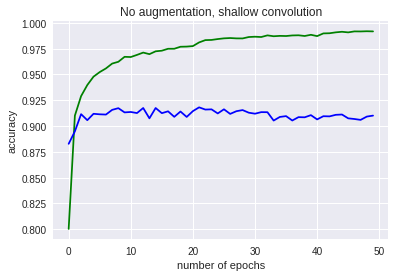

In [171]:
# No augmentation, shallow  ===> we see an overfitting problem !
x = res[0]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('No augmentation, shallow convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

Final accuracy obtain: 91.8550010383129 / 100 % 



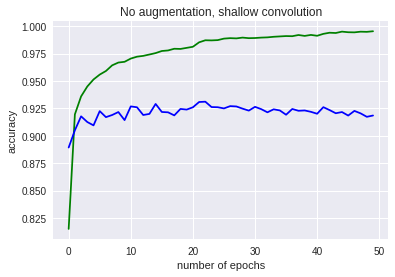

In [172]:
# No augmentation, Deep ==> better accuracy but still overfit a lot
x = res[1]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('No augmentation, shallow convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

Final accuracy obtain: 92.92000084519387 / 100 % 



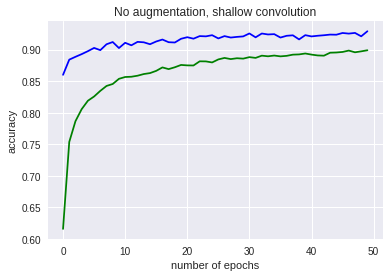

In [173]:
# Augmentation, shallow ==> no more overfitting and much better result

x = res[2]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('No augmentation, shallow convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

Final accuracy obtain: 93.15500075817108 / 100 % 



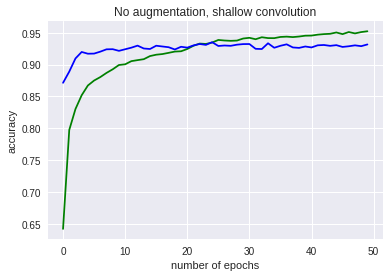

In [174]:
# Augmentation, deep ==> decent result !!

x = res[3]
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
plt.title('No augmentation, shallow convolution')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

print("Final accuracy obtain: " + str(test[-1]*100) + " / 100 % \n")

# Test Time augmentation

In [0]:
# Test time augmentation
def transform_dataset_multi(images, aff=lambda x:x, nsamp=5):
    """ 
        Todo.
    """
    x = [transform_image_multi(im, aff, nsamp) for im in images]
    return torch.cat(x).float().to(device)

def transform_image_multi(im, aff, nsamp):
    """ 
        Split class ids between support set and query set.
    """
    im = [transform_image(im, aff) for i in range(nsamp)]
    im = torch.cat(im)
    return im.unsqueeze(0)

#def transform_image(im, aff):
#    im = aff(im)
#    im = im.resize((28,28))
#    im = np.array(im).astype("uint8")
#    im = torch.from_numpy(im)
#    return im.unsqueeze(0)

#def transform_image(im, aff):
#    im = aff(im)
#    im = im.resize((28,28))
#    im = np.array(im)
#    im = torch.from_numpy(im)
#    return im.unsqueeze(0)

def index_bid_multi(x, y, support, query):
    """ 
        Todo.
    """
    return x[support].view(-1, 28, 28), y[query].view(-1, 28, 28)

def sample_batch_multi(x, y, n_class, n_way, k_shot, n_samp=20):
    """ 
        Todo.
    """
    bid = get_batch_ids(n_class, n_way, k_shot, n_samp)
    support, query = sample_set_ids(bid)
    return index_bid_multi(x, y, support, query)

class OmniGlotDsMulti():
    def __init__(self, classes, k_shot=5, n_way=60, n_samp=20, n_trans=10, n_iter=100, 
                 query_transform=None, proto_transform=None):
        """ 
            Todo.
        """
        self.x,self.y = load_data(classes)
        self.n_class = len(self.y.cpu().unique())
        self.n_iter = n_iter
        self.k_shot = k_shot
        self.n_way  = n_way
        self.n_samp = n_samp
        self.n_trans= n_trans
        self.query_transform = query_transform if query_transform else lambda x:x
        self.proto_transform = proto_transform if proto_transform else lambda x:x
        self.generate_split()
        self.generate_query_split()
        
    def generate_query_split(self):
        self.queries = transform_dataset(self.x, self.query_transform)
        
    def generate_split(self):
        self.support = transform_dataset_multi(self.x, self.proto_transform, self.n_trans)
        
    def sample(self):
        return sample_batch_multi(self.support, self.queries,
                                  self.n_class, self.n_way, 
                                  self.k_shot*2, self.n_samp)
    
    def __iter__(self):            
        for i in range(self.n_iter):
            yield self.sample()
            
    def __len__(self):
        return self.n_iter

In [0]:
def test_multi(model, ds):
    '''
        Run the test with test time augmentation:
         -> ds = OmniGlotDSMulti
    '''
    accuracy = []
    model.eval()
    n_way = ds.n_way
    k_shot = ds.n_trans
    lbl = torch.from_numpy(np.arange(n_way)).to(device)
    for xim, yim in tqdm(ds):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(n_way, k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        _, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
    return accuracy

## train multi ??

In [0]:
Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1))
N_TRANS = [1, 2, 3, 3, 5, 7, 10, 12, 15, 30, 40, 50, 60, 80, 90, 100, 110, 120, 130, 140, 150, 160, 180]  ## TO RE RUN

n_iter = 1000
print_freq=1

#MODEL TO USE
model_ntrans = models_[-1]  ## HERE SELECT THE MODEL YOU WANNA USE
test_acc_trans = []
#loading train set
ds_train = OmniGlotDs(train_class, transform=Aff, k_shot=1, n_iter=n_iter)#

for NTRA in N_TRANS:
    
    #loading test set
    ds_test  = OmniGlotDsMulti(test_class,query_transform=None, proto_transform=Aff, k_shot=1, n_way=20, n_iter=n_iter,n_trans=NTRA)
    te_acc = test_multi(model_ntrans,ds_test)
    test_acc_trans.append(np.mean(te_acc))

In [0]:
plt.plot(N_TRANS, test_acc_trans, color='blue')
plt.title("TTA : test acc depending on nb of transform ")
plt.xlabel('nb trans')
plt.ylabel('acc')

# vizualising TTA effect

In [0]:
colors = np.random.rand(20, 3)

def print_tsne(support, query, figsize=(10,10)):
    nclass = query.size(0)
    nsamp = int(support.size(0) / nclass)
    if "cuda" in device:
        data_points = torch.cat([support, query]).cpu().detach().numpy()
    else:
        data_points = torch.cat([support, query]).detach().numpy()
    points = TSNE(2).fit_transform(data_points)
    
    support_p = points[:nclass*nsamp]
    query_p = points[nclass*nsamp:]
    
    fig, axes = plt.subplots(1,1, figsize=figsize)
    for i in range(nclass):
        axes.scatter(support_p[i*nsamp:(i+1)*nsamp, 0], support_p[i*nsamp:(i+1)*nsamp,1], 
                     color=colors[i], marker="o", alpha=0.5)
        axes.scatter(query_p[i:(i+1),0], query_p[i:(i+1),1], color=colors[i], 
                     marker="v", linewidths=.5, edgecolors="k", alpha=1)

def plot_test_sample(model, ds):
    model.eval()
    n_way = ds.n_way
    k_shot = ds.n_trans
    
    for xim, yim in ds:
        break
        
    inp = torch.cat([xim,yim]).unsqueeze(1)
    out = model(inp)
    
    support = out[:n_way*k_shot]
    query = out[n_way*k_shot:]
    print_tsne(support, query)

In [0]:
# Avec data augmentation
n_trans = 10
ds_te = OmniGlotDsMulti(test_class,  proto_transform=Aff, 
                          k_shot=1, n_iter=1, 
                          n_way=20, n_trans=n_trans)

In [0]:
plt.style.use("dark_background")
plot_test_sample(model_ntrans, ds_te)

# changing the N_WAYS at training time

**ACCORDING to the [paper](http://papers.nips.cc/paper/6996-prototypical-networks-for-few-shot-learning.pdf)** : *"We trained Prototypical Networks using Euclidean
distance in the 1-shot and 5-shot scenarios
with training episodes containing 60 classes
and 5 query points per class. We found that it
is advantageous to match the training-shot with
the test-shot, and to use more classes (higher
“way”) per training episode rather than fewer.""*


Let's then explore this !!

In [0]:
Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1))
N_WAYS = [5, 10, 20, 30, 45, 60, 80, 100, 120, 140]#, 160]  ## TO RE RUN
#N_WAYS = [90, 120, 150]
results_nways = {}
models_nways = {}
#nepochs = 30
nepochs = 30
n_iter = 1000
print_freq=1
LOAD_MODEL = True

#loading test set
ds_test  = OmniGlotDs(test_class, k_shot=1, n_way=20, n_iter=n_iter)

for NWAY in N_WAYS:
    model_path = "./omniglot_20ways_1shot/saved_models/model_" + str(NWAY) + "_nways_" + str(nepochs) + "_epochs"
    
    #loading train set
    ds_train = OmniGlotDs(train_class, transform=Aff, k_shot=1, n_iter=n_iter, n_way=NWAY)
    
    if LOAD_MODEL:
        model_nways = get_model(model_path)
        if model_nways:
            print('MODEL UPLOADED')
            losses, tr_acc = None, None # no relevant here #get_loss_acc(model_nways, ds_train)
            #tr_acc = test_model(model_nways, ds_train)
            te_acc = test_model(model_nways, ds_test)
            results_nways[(NWAY)] = losses, tr_acc, te_acc
        else:
            print('MODEL NOT FOUND , creating one...')
            model_nways = ProtoNet(conv_block=conv_block_deep).to(device)

            # Adam and LR
            optim = torch.optim.Adam(params=model_nways.parameters(), lr=learning_rate)
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                           gamma=lr_scheduler_gamma,
                                                           step_size=lr_scheduler_step)
            # Training
            losses, tr_acc, te_acc = train_model(model_nways, optim, ds_train, ds_test, lr_scheduler, nepochs=nepochs, print_freq=print_freq)
            results_nways[(NWAY)] = losses, tr_acc, te_acc
            models_nways[(NWAY)] = model_nways
            # saving the model
            try:
                #print("Saving the model_" + str(NWAY) + "_nways_" + str(nepochs) + "_epochs")
                torch.save(model_nways.state_dict(), model_path)
                files.download(model_path)
            except Exception as e:
                print("Exception while saving model :" + str(e))

In [74]:
res_nways = []
for NWAY in N_WAYS:
    res_nways.append(results_nways[(NWAY)]) #= losses, tr_acc, te_acc

Saving the results ./omniglot_20ways_1shot/saved_results/result_5_nways_30_epochs
Saving the results ./omniglot_20ways_1shot/saved_results/result_10_nways_30_epochs
Saving the results ./omniglot_20ways_1shot/saved_results/result_20_nways_30_epochs
Saving the results ./omniglot_20ways_1shot/saved_results/result_30_nways_30_epochs
Saving the results ./omniglot_20ways_1shot/saved_results/result_45_nways_30_epochs
Saving the results ./omniglot_20ways_1shot/saved_results/result_60_nways_30_epochs
Saving the results ./omniglot_20ways_1shot/saved_results/result_80_nways_30_epochs
Saving the results ./omniglot_20ways_1shot/saved_results/result_100_nways_30_epochs
Saving the results ./omniglot_20ways_1shot/saved_results/result_120_nways_30_epochs
Saving the results ./omniglot_20ways_1shot/saved_results/result_140_nways_30_epochs


In [0]:
### TMP
res_nways = []
#N_WAYS = [5,10,20,30]
for NWAY in N_WAYS:
    res_nways.append(results_nways[(NWAY)]) #= losses, tr_acc, te_acc
    # saving the result
    try:
        result_pickle_name = "./omniglot_20ways_1shot/saved_results/result_" + str(NWAY) + "_nways_" + str(nepochs) + "_epochs"
        print("Saving the results " + result_pickle_name)
        save_object(filename=result_pickle_name,obj=results_nways[(NWAY)])
        files.download(result_pickle_name)
    except Exception as e:
        print("Exception while saving results :" + str(e))

In [0]:
!mkdir ./omniglot_20ways_1shot/saved_results

In [0]:
try:
    loss = [np.mean(x[0]) for x in res_nways]
    train = [np.mean(x[1]) for x in res_nways]
except Exception as e:
    pass
test = [np.mean(x[2]) for x in res_nways]

In [33]:
!ls ./omniglot_20ways_1shot/saved_models | grep 30_e

model_100_nways_30_epochs
model_10_nways_30_epochs
model_120_nways_30_epochs
model_140_nways_30_epochs
model_20_nways_30_epochs
model_30_nways_30_epochs
model_45_nways_30_epochs
model_5_nways_30_epochs
model_60_nways_30_epochs
model_80_nways_30_epochs


In [0]:
files.download("./omniglot_20ways_1shot/saved_models/model_140_nways_30_epochs")

Text(0.5,1,'test acc regarding nway at training')

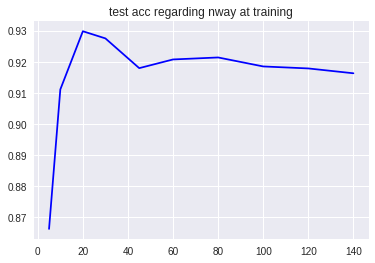

In [40]:
#plt.plot(N_WAYS, train, color='green')
plt.plot(N_WAYS, test, color='blue')
plt.title("test acc regarding nway at training")

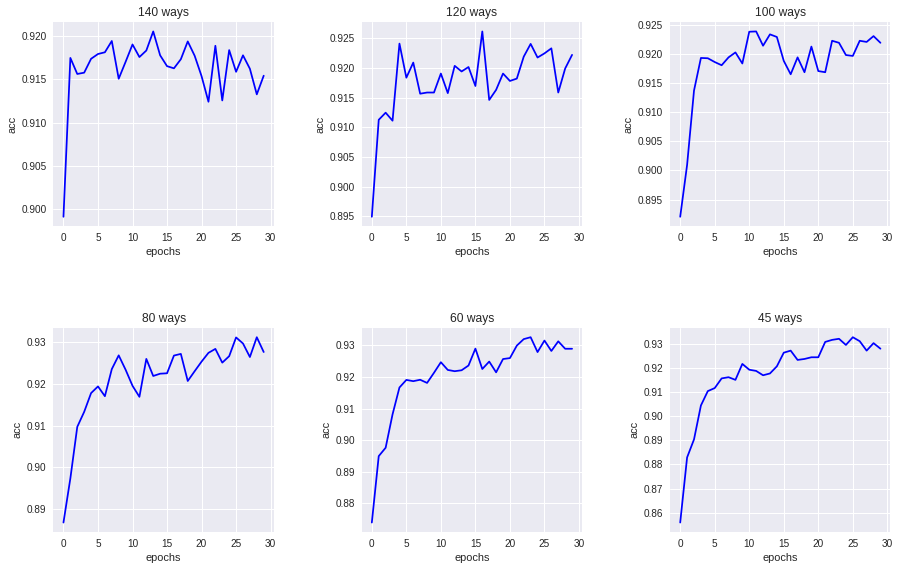

In [91]:
w=12
h=12
fig=plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

columns = 3
rows = 3
for i in range(1, 7):
    fig.add_subplot(rows, columns, i)
    x = res_nways[-i]
    loss = [np.mean(x_) for x_ in x[0]]
    train = [np.mean(x_) for x_ in x[1]]
    test = [np.mean(x_) for x_ in x[2]]
    x_train = range(nepochs)
    x_test = range(0,nepochs,print_freq)

    plt.plot(x_test, test, color='blue')
    plt.title(str(N_WAYS[-i]) + ' ways')
    plt.xlabel("epochs")
    plt.ylabel("acc")

test[-i]
plt.show()

In [0]:
## seems it has not fully converge and still having a growings for 45, 60, 80, 100 ways
## for 120 and 140 it's still looks quite unstable => might requires much more training... Due to time contraints, let's focus on others values : 20, 60, 100 80
## let's then do further epochs 

In [0]:
Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1))
N_WAYS = [20, 60, 80, 100]#, 120, 140]#, 160]  ## TO RE RUN
#N_WAYS = [90, 120, 150]
results_nways = {}
models_nways = {}
#nepochs = 30
nepochs = 50
n_iter = 1000
print_freq=1
LOAD_MODEL = True

#loading test set
ds_test  = OmniGlotDs(test_class, k_shot=1, n_way=20, n_iter=n_iter)

for NWAY in N_WAYS:
    model_path = "./omniglot_20ways_1shot/saved_models/model_" + str(NWAY) + "_nways_" + str(nepochs) + "_epochs"
    
    #loading train set
    ds_train = OmniGlotDs(train_class, transform=Aff, k_shot=1, n_iter=n_iter, n_way=NWAY)
    
    if LOAD_MODEL:
        model_nways = get_model(model_path)
        if model_nways:
            print('MODEL UPLOADED')
            losses, tr_acc = None, None # no relevant here #get_loss_acc(model_nways, ds_train)
            #tr_acc = test_model(model_nways, ds_train)
            te_acc = test_model(model_nways, ds_test)
            results_nways[(NWAY)] = losses, tr_acc, te_acc
        else:
            print('MODEL NOT FOUND , creating one...')
            model_nways = ProtoNet(conv_block=conv_block_deep).to(device)

            # Adam and LR
            optim = torch.optim.Adam(params=model_nways.parameters(), lr=learning_rate)
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                           gamma=lr_scheduler_gamma,
                                                           step_size=lr_scheduler_step)
            # Training
            losses, tr_acc, te_acc = train_model(model_nways, optim, ds_train, ds_test, lr_scheduler, nepochs=nepochs, print_freq=print_freq)
            results_nways[(NWAY)] = losses, tr_acc, te_acc
            models_nways[(NWAY)] = model_nways
            # saving the model
            try:
                #print("Saving the model_" + str(NWAY) + "_nways_" + str(nepochs) + "_epochs")
                torch.save(model_nways.state_dict(), model_path)
                files.download(model_path)
            except Exception as e:
                print("Exception while saving model :" + str(e))

# test most optimized model

In [0]:
#### ATTENTION -> no LOAD_MODEL here because we below plots the train acc and test acc evolution with epochs


Aff = torchvision.transforms.RandomAffine(15, shear=25, scale=(.8,1.1))
n_way = 100 #[20, 60, 90, 120, 150]  ## TO RE RUN
#N_WAYS = [90, 120, 150]
results_optim = {}
nepochs = 40
#nepochs = 1
print_freq=1
device="cuda:0"
##device="cpu"
n_iter=1000


model_path_optim  = "./omniglot_20ways_1shot/saved_models/model_optim_" + str(n_way) + "_nways_" + str(nepochs) + "_epochs"



ds_train = OmniGlotDs(train_class, transform=Aff, k_shot=1, n_iter=n_iter, n_way=n_way)
ds_test  = OmniGlotDs(test_class, k_shot=1, n_way=20, n_iter=n_iter)

model_optim = ProtoNet(conv_block=conv_block_deep).to(device)
optim = torch.optim.Adam(params=model_optim.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                               gamma=lr_scheduler_gamma,
                                               step_size=lr_scheduler_step)
# Augmentation
losses, tr_acc, te_acc = train_model(model_optim, optim, ds_train, ds_test, lr_scheduler, nepochs=nepochs, print_freq=print_freq)
results_optim = losses, tr_acc, te_acc
# saving the model
try:
    torch.save(model_optim.state_dict(), model_path_optim)
    files.download(model_path_optim)
except Exception as e:
    print("Exception while saving model :" + str(e))

In [0]:
# No augmentation, shallow
x = results_optim
loss = [np.mean(x_) for x_ in x[0]]
train = [np.mean(x_) for x_ in x[1]]
test = [np.mean(x_) for x_ in x[2]]
x_train = range(nepochs)
x_test = range(0,nepochs,print_freq)

plt.plot(x_train, train, color='green')
plt.plot(x_test, test, color='blue')
#plt.plot(x_train, loss, color='red')
plt.title('Most Optim ')
plt.xlabel('epochs')
plt.ylabel.('acc')

test[-1]

In [0]:
max(test)

# testing otimized model on challenge script data !

In [0]:
!mkdir data_challenge

In [0]:
!unzip -qq ./omniglot/python/one-shot-classification/all_runs.zip -d data_challenge

In [0]:
!ls data_challenge

In [0]:
#challenge_model = ProtoNet(conv_block=conv_block_shallow).to(device) ### WHYYYYYYY SHALLOW !!!! 
# TMP ProtoNet(conv_block=conv_block_shallow).to(device) ### WHYYYYYYY SHALLOW !!!! model_path_optim
LOAD_MODEL = True
challenge_model_path = model_path_optim

if LOAD_MODEL:
    challenge_model = get_model(challenge_model_path)
    if challenge_model:
        print('MODEL UPLOADED CORRECTLY !')
    else:
        print('SORRY ! MODEL NOT FOUND. Please make sure your challenge_model_path is correct or train one with the above section')
else:
    try:
        challenge_model = model_optim
    except Exception as e:
        print("please make sure you have run the above section to get your optim or load one setting LOAD_MODEL=True")

In [0]:
# Splits of the challenge 
class ChallengeDataset(object):
    def __init__(self, root, nsamp):
        self.runs = []
        self.n_way = 20
        self.k_shot = nsamp
        self.base = root
        
        for run in os.listdir(root):
            fp = pj(root, run, "class_labels.txt")
            train, test = self._read_run(fp)
            self.runs.append([train, test])
            
    def __len__(self):
        return len(self.runs)
    
    def __iter__(self):
        for run in self.runs:
            yield run
            
    def _read_run(self, fp):
        with open(fp) as f:
            content = f.read().splitlines()
            pairs = [line.split() for line in content]
            test_files  = [pair[0] for pair in pairs]
            train_files = [pair[1] for pair in pairs]
        
        im = [read_image(pj(self.base, im)) for im in test_files]
        train = transform_dataset(im).view(-1,28,28)

        im = [read_image(pj(self.base, im)) for im in train_files]
        test = transform_dataset(im)
        
        return train, test
    
def read_image(fp, size=(28,28)):
    """
        read the image under fp filepath and resize it.
    """
    im = Image.open(fp)
    im = im.convert("L")
    im = ImageOps.invert(im)
    return im.resize(size)

    
def test_challenge(model, ds_test):
    accuracy = []
    model.eval()
    n_way = ds_test.n_way
    k_shot = ds_test.k_shot
    lbl = torch.from_numpy(np.arange(n_way)).to(device)
    print(lbl.size())
    for xim, yim in tqdm(ds_test):
        inp = torch.cat([xim,yim]).unsqueeze(1)
        out = model(inp)
        proto = out[:n_way*k_shot]
        proto = proto.view(ds_test.n_way, ds_test.k_shot,-1).mean(1)
        query = out[n_way*k_shot:]
        _, acc = lossfunc(proto, query, lbl)
        accuracy.append(acc)
    return accuracy

In [0]:
ds_challenge = ChallengeDataset("./data_challenge", 1)
challenge_acc = test_challenge(challenge_model, ds_challenge)
print("Accuracy in the challenge test = " + str(np.mean(challenge_acc)))

# tests